In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%cd ..

c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo


In [2]:
import sys
import os

import numpy as np
import pandas as pd
import random
import tensorflow as tf

from tensorflow import keras
from keras import layers
from scipy import stats

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

from scripts.CustomCallbacks import CustomLogger
import scripts.utils as utils
import scripts.Slopes as Slopes

from tqdm import tqdm
import json

from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import operator
import statsmodels.api as sm

utils.reset_seeds(0)
pd.set_option('display.max_columns', 50)

In [3]:
sns.set_context("paper")
sns.set_style('ticks')

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams["font.family"] = "Calibri"
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['legend.title_fontsize'] = 15
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['savefig.dpi'] = 600

In [4]:
paths = ["andmed3/all_four/const_order.csv", "andmed3/all_four/const_reverse.csv", "andmed3/all_four/sin_order.csv", "andmed3/all_four/sin_reverse.csv"]
df_koik = pd.concat([utils.read_aggregated_data(path) for path in paths], axis=0)
df_koik.shape

(1900, 41)

In [5]:
regioon = ['a', 'b', 'c', 'd', 'e']
naabrid = [['b'], ['a','c'], ['b','d'], ['c','e'], ['d']]
kaugemad = [['c'], ['d'], ['a','e'], ['b'], ['c']]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

def treeni_ols_no_p_drop(X, y):
    """Võtab sisse transformeeritud X ja y ning tagastab OLS mudeli.

    :param X: x andmed
    :param y: y
    :return: model, x, y
    """
    
    X = sm.add_constant(X)
    kasutusel_featured = {col: 1 for col in X.columns}

    model = sm.OLS(y, X)

    results = model.fit()

    print(results.rsquared, sep=";", end=";")
    print(results.mse_model, sep=";", end=";")
    print(results.aic, sep=";", end=";")
    print(results.bic, sep=";", end=";")
    print()
    # print(results.summary())
    return results, X, y

In [6]:
def muuda_veergude_nimed_eestikeelseks(df):
    eesti_nimed = {
        'const': 'Konstant',
        'my_bpoints': 'Murde_enda',
        'neighbour_bpoints': 'Murde_naaber',
        'distant_bpoints': 'Murde_kauge',
        'my_raw_mean2': 'EnnustatudDispersioon_enda',
        'neighbour_raw_mean2': 'EnnustatudDispersioon_naaber',
        'distant_raw_mean2': 'EnnustatudDispersioon_kauge',
        'my_points': 'Punkte_enda',
        'neighbour_points': 'Punkte_naaber',    
        'distant_points': 'Punkte_kauge',
        'my_points_m1': '1/Punkte_enda',
        'my_points_log': 'ln(Punkte_enda)',
        'my_points_logm1': '1/ln(Punkte_enda)',
        'neighbour_points_m1': '1/Punkte_naaber',
        'neighbour_points_log': 'ln(Punkte_naaber)',
        'neighbour_points_logm1': '1/ln(Punkte_naaber)',
        'distant_points_m1': '1/Punkte_kauge',
        'distant_points_log': 'ln(Punkte_kauge)',
        'distant_points_logm1': '1/ln(Punkte_kauge)',
        'mse_treeningul': 'MSE treeningul',
        'points_combo': 'Punkte_kombi',
        'bpoints_combo': 'Murde_kombi',
    }
    df = df.rename(columns=eesti_nimed)
    return df

# Treenime OLS, backwards regression

In [7]:
Xid, yid = [], []

for r, n, k in regioonide_combod:

    andmestikud_koos = pd.concat([utils.read_aggregated_data(
        paths[p]) for p in range(4)], ignore_index=True)
    X, y = utils.transform_no_scaling(andmestikud_koos, r, n, k)
    Xid.append(X)
    yid.append(y)


In [8]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
suurX = sm.add_constant(suurX)

In [9]:
def backward_stepwise_regression(X, y,):
    remaining_features = list(X.columns)
    best_r2 = 0
    best_subset = remaining_features
    
    subsets = [remaining_features[:i] + remaining_features[i+1:] for i in range(len(remaining_features))]
    r2_scores = []
    models = []
    for subset in subsets:
        model = sm.OLS(y, X[subset]).fit()
        r2_scores.append(model.rsquared)
        models.append(model)

    asjad_koos = sorted(list(zip(r2_scores, subsets, models)), key=lambda x:x[0], reverse=True)
    if "const" in asjad_koos[0][1] or "Konstant" in asjad_koos[0][1]:
        return asjad_koos[0]
    else:
        return asjad_koos[1]

best_r2, best_subset, result  = backward_stepwise_regression(suurX, suury,)
print("Best subset of predictor variables:", best_subset)
print("Removed predictor variables:", list(set(suurX.columns) - set(best_subset)))
print("Best R² score:", best_r2)

Best subset of predictor variables: ['const', 'my_bpoints', 'neighbour_bpoints', 'distant_bpoints', 'my_raw_mean2', 'neighbour_raw_mean2', 'distant_raw_mean2', 'my_points', 'neighbour_points', 'distant_points', 'my_points_m1', 'my_points_log', 'my_points_logm1', 'neighbour_points_m1', 'neighbour_points_log', 'neighbour_points_logm1', 'distant_points_m1', 'distant_points_logm1', 'mse_treeningul']
Removed predictor variables: ['distant_points_log']
Best R² score: 0.7250389224447805


In [157]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
suurX = sm.add_constant(suurX)

suurX = muuda_veergude_nimed_eestikeelseks(suurX)

resulting_r2s = []
removed_features = []
mudelid = []
subsetid = []
while len(suurX.columns) > 1:
    best_r2, best_subset, result = backward_stepwise_regression(suurX, suury)
    significant = [p_value < 0.05 for p_value in result.pvalues]
    if all(significant):
        print("kõik on olulised")
    print("Best subset of predictor variables:", best_subset)
    removed_features.append(list(set(suurX.columns) - set(best_subset))[0])
    print("Removed predictor variables:", removed_features[-1])
    print("Best R² score:", best_r2)
    print()
    suurX = suurX[best_subset]
    subsetid.append(best_subset)
    resulting_r2s.append(best_r2)
    mudelid.append(result)

Best subset of predictor variables: ['Konstant', 'Murde_enda', 'Murde_naaber', 'Murde_kauge', 'EnnustatudDispersioon_enda', 'EnnustatudDispersioon_naaber', 'EnnustatudDispersioon_kauge', 'Punkte_enda', 'Punkte_naaber', 'Punkte_kauge', '1/Punkte_enda', 'ln(Punkte_enda)', '1/ln(Punkte_enda)', '1/Punkte_naaber', 'ln(Punkte_naaber)', '1/ln(Punkte_naaber)', '1/Punkte_kauge', '1/ln(Punkte_kauge)', 'MSE treeningul']
Removed predictor variables: ln(Punkte_kauge)
Best R² score: 0.7250389224447805

Best subset of predictor variables: ['Konstant', 'Murde_enda', 'Murde_naaber', 'Murde_kauge', 'EnnustatudDispersioon_enda', 'EnnustatudDispersioon_naaber', 'EnnustatudDispersioon_kauge', 'Punkte_enda', 'Punkte_naaber', 'Punkte_kauge', '1/Punkte_enda', 'ln(Punkte_enda)', '1/ln(Punkte_enda)', '1/Punkte_naaber', '1/ln(Punkte_naaber)', '1/Punkte_kauge', '1/ln(Punkte_kauge)', 'MSE treeningul']
Removed predictor variables: ln(Punkte_naaber)
Best R² score: 0.7250308355030174

Best subset of predictor variabl

parimad_subsetid ['Konstant', 'Murde_enda', 'EnnustatudDispersioon_enda', '1/Punkte_enda', 'ln(Punkte_enda)', 'MSE treeningul']


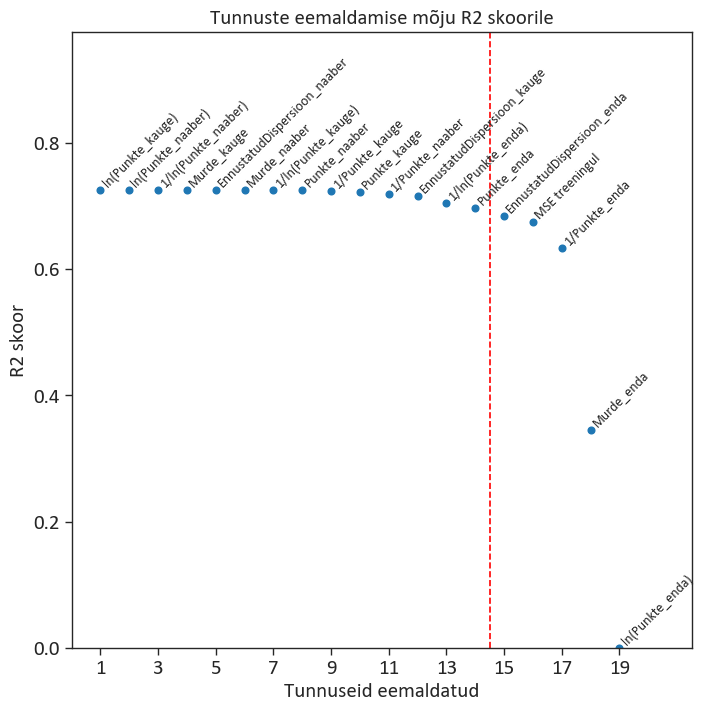

In [160]:
plt.vlines(x=14.5, ymin=0, ymax=max(resulting_r2s)+0.25, linestyles='--', color="r")
plt.plot(range(1, 20), resulting_r2s, "o")

for i, feature_name in enumerate(removed_features, start=1):
    # plt.annotate(feature_name, (i+0.5, resulting_r2s[i-1]+ 0.002), fontsize=10, ha='center', va='bottom', rotation=60)
    plt.annotate(feature_name, (i, resulting_r2s[i-1]+0.001), fontsize=10, rotation=45, ha='left', va='bottom')#,  textcoords='offset pixels')


plt.xlabel("Tunnuseid eemaldatud")
plt.ylabel("R2 skoor")
plt.title("Tunnuste eemaldamise mõju R2 skoorile")

plt.xticks(range(1, 20, 2))
plt.ylim(0, max(resulting_r2s)+0.25)
plt.xlim(0, 21+0.5)
print("parimad_subsetid", subsetid[13])
# tunnused mis on 10 tk dropitud:
plt.savefig("plots3/kirjalik_osa/ols_backward_stepwise_koik_tunnused.png", bbox_inches='tight')

In [161]:
mudelid[13].bic

-17299.117816605736

In [162]:
valitud_mudel = mudelid[13]
valitud_mudel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     3679.
Date:                Tue, 09 May 2023   Prob (F-statistic):               0.00
Time:                        02:58:54   Log-Likelihood:                 8676.5
No. Observations:                8050   AIC:                        -1.734e+04
Df Residuals:                    8044   BIC:                        -1.730e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Konstant                      -0.1141      0.005    -21.968      0.000      -0.124      -0.104
Murde_enda                    -0.3563      0.005    -67.264      0.000      -0.367      -0.346
EnnustatudDispersioon_enda     0.2138      0.012     18.243      0.000       0.191       0.237
1/Punkte_enda                 -0.4783      0.014    -34.313      0.000      -0.506      -0.451
ln(Punkte_enda)                0.2866      0.008     35.553      0.000       0.271       0.302
MSE treeningul                -0.0982      0.005    -20.707      0.000      -0.108      -0.089
==============================================================================
Omnibus:                     1898.259   Durbin-Watson:                   0.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           104467.569
Skew:                           0.149   Prob(JB):                         0.00
Kurtosis:                      20.646   Cond. No.                         20.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [163]:
valitud_mudel = mudelid[13]

summary_table = pd.read_html(valitud_mudel.summary().as_html(), header=0, index_col=0)
with pd.ExcelWriter(r"plots3\kirjalik_osa\koigi_tunnustega_r2backwards.xlsx", engine='openpyxl') as writer:
    summary_table[1].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)


## Vaatame ainult punkte grupikaupa, org, m1, log, logm1

<!-- * originaal_tunnus: 
  * 0.283
  * my, naaber
* m1:
  * 0.452
  * my, naaber, distant
* log:
  * 0.408
  * my, naaber, distant
* logm1:
  * 0.415
  * my, naaber -->
* 0.703 logm1
* 0.679 m1
* 0.658 log
* 0.417 originaal
  
<!-- originaal ja m1 on 9 tunnusega, log 11 ja logm1 10ga -->

In [38]:
def remove_most_insignificant(df, results):
    # use operator to find the key which belongs to the maximum value in the dictionary:
    max_p_value = max(results.pvalues.items(), key=operator.itemgetter(1))[0]
    # this is the feature you want to drop:
    # print(f'Dropping feature: {max_p_value}')
    df.drop(columns=max_p_value, inplace=True)
    return df, max_p_value

def treeni_ols(X, y):
    """Võtab sisse transformeeritud X ja y ning tagastab OLS mudeli.

    :param X: x andmed
    :param y: y
    :return: model, x, y
    """
    
    kasutusel_featured = {col: 1 for col in X.columns}

    insignificant_feature = True
    X["Konstant"] = 1
    
    while insignificant_feature:
        
        model = sm.OLS(y, X)
        results = model.fit()
        significant = [p_value < 0.05 for p_value in results.pvalues]
        if all(significant):
            insignificant_feature = False
        else:
            if X.shape[1] == 1:
                print('No significant features found')
                results = None
                insignificant_feature = False
            else:
                X, removed = remove_most_insignificant(X, results)
                kasutusel_featured[removed] = 0
    return results, X, y

def loe_andmed_uuesti():
    Xid, yid = [],[]

    for r, n, k in regioonide_combod:
        
        andmestikud_koos = pd.concat([utils.read_aggregated_data(paths[p]) for p in range(4)], ignore_index=True)

        X, y = utils.transform_no_scaling(andmestikud_koos, r, n, k)

        Xid.append(X)
        yid.append(y)
    return Xid, yid

def kombineeri_tunnus_mudelist_ja_dfist(mudel, df):
    series = np.zeros(shape=df.shape[0])
    for param in mudel.params.keys():
        if param!="const":
            series += df[param] * mudel.params[param] 
        else:
            series += np.ones(shape=df.shape[0]) * mudel.params["const"]
    return series

In [39]:
Xid, yid = loe_andmed_uuesti()

In [40]:
alati_ok = ['my_bpoints', 'neighbour_bpoints', 'distant_bpoints', 'my_raw_mean2', 'neighbour_raw_mean2', 'distant_raw_mean2', 'mse_treeningul']
punkti_tunnused = ['my_points', 'neighbour_points', 'distant_points', 'my_points_m1', 'my_points_log', 'my_points_logm1', 'neighbour_points_m1', 'neighbour_points_log', 'neighbour_points_logm1', 'distant_points_m1', 'distant_points_log', 'distant_points_logm1', ]

In [41]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

suurX = suurX[[col for col in suurX.columns if col in alati_ok or col.endswith("points") ]]

uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result, newX, newy = treeni_ols(suurX, suury)
print(len(result.params.keys()))
result.summary()

9


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     719.0
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        15:20:41   Log-Likelihood:                 6059.0
No. Observations:                8050   AIC:                        -1.210e+04
Df Residuals:                    8041   BIC:                        -1.204e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
my_bpoints           -0.3348      0.008    -43.048      0.000      -0.350      -0.320
distant_bpoints       0.0304      0.008      4.047      0.000       0.016       0.045
my_raw_mean2          0.2146      0.018     12.215      0.000       0.180       0.249
distant_raw_mean2    -0.0701      0.016     -4.381      0.000      -0.102      -0.039
my_points             0.2755      0.022     12.488      0.000       0.232       0.319
neighbour_points      0.2305      0.024      9.412      0.000       0.182       0.279
distant_points        0.1589      0.023      6.932      0.000       0.114       0.204
mse_treeningul       -0.1187      0.008    -15.593      0.000      -0.134      -0.104
Konstant             -0.0479      0.006     -7.861      0.000      -0.060      -0.036
==============================================================================
Omnibus:                     3013.207   Durbin-Watson:                   0.626
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17800.115
Skew:                          -1.684   Prob(JB):                         0.00
Kurtosis:                       9.460   Cond. No.                         26.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

suurX = suurX[[col for col in suurX.columns if col in alati_ok or col.endswith("points_m1") ]]
uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result, newX, newy = treeni_ols(suurX, suury)
print(len(result.params.keys()))
result.summary()

11


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     1700.
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        15:20:42   Log-Likelihood:                 8460.3
No. Observations:                8050   AIC:                        -1.690e+04
Df Residuals:                    8039   BIC:                        -1.682e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
my_bpoints             -0.3358      0.006    -57.284      0.000      -0.347      -0.324
neighbour_bpoints       0.0233      0.006      3.661      0.000       0.011       0.036
distant_bpoints         0.0331      0.006      5.589      0.000       0.021       0.045
my_raw_mean2            0.1882      0.017     11.014      0.000       0.155       0.222
neighbour_raw_mean2     0.0373      0.018      2.131      0.033       0.003       0.072
distant_raw_mean2      -0.0855      0.013     -6.507      0.000      -0.111      -0.060
my_points_m1           -0.5447      0.015    -35.301      0.000      -0.575      -0.514
neighbour_points_m1    -0.2469      0.018    -13.714      0.000      -0.282      -0.212
distant_points_m1      -0.1818      0.016    -11.177      0.000      -0.214      -0.150
mse_treeningul         -0.1130      0.006    -18.547      0.000      -0.125      -0.101
Konstant                0.0452      0.006      7.624      0.000       0.034       0.057
==============================================================================
Omnibus:                     2374.251   Durbin-Watson:                   0.886
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           114186.783
Skew:                           0.645   Prob(JB):                         0.00
Kurtosis:                      21.406   Cond. No.                         29.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

suurX = suurX[[col for col in suurX.columns if col in alati_ok or col.endswith("points_log") ]]

uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result, newX, newy = treeni_ols(suurX, suury)
print(len(result.params.keys()))
result.summary()

9


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     1931.
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        15:20:45   Log-Likelihood:                 8201.5
No. Observations:                8050   AIC:                        -1.638e+04
Df Residuals:                    8041   BIC:                        -1.632e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
my_bpoints              -0.3676      0.006    -60.872      0.000      -0.379      -0.356
neighbour_bpoints       -0.0489      0.007     -7.269      0.000      -0.062      -0.036
distant_bpoints         -0.0409      0.006     -6.552      0.000      -0.053      -0.029
my_raw_mean2             0.1322      0.014      9.427      0.000       0.105       0.160
distant_raw_mean2       -0.0919      0.013     -7.319      0.000      -0.116      -0.067
my_points_log            0.4705      0.013     37.586      0.000       0.446       0.495
neighbour_points_log     0.0495      0.013      3.849      0.000       0.024       0.075
mse_treeningul          -0.0521      0.006     -8.871      0.000      -0.064      -0.041
Konstant                -0.2020      0.005    -36.837      0.000      -0.213      -0.191
==============================================================================
Omnibus:                     2572.570   Durbin-Watson:                   0.765
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31462.006
Skew:                          -1.179   Prob(JB):                         0.00
Kurtosis:                      12.394   Cond. No.                         24.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

suurX = suurX[[col for col in suurX.columns if col in alati_ok or col.endswith("points_logm1") ]]

uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result, newX, newy = treeni_ols(suurX, suury)
print(len(result.params.keys()))
result.summary()

9


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     2379.
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        15:20:46   Log-Likelihood:                 8773.4
No. Observations:                8050   AIC:                        -1.753e+04
Df Residuals:                    8041   BIC:                        -1.747e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
my_bpoints                -0.3502      0.005    -63.858      0.000      -0.361      -0.339
neighbour_bpoints         -0.0129      0.006     -2.238      0.025      -0.024      -0.002
my_raw_mean2               0.1711      0.013     13.406      0.000       0.146       0.196
distant_raw_mean2         -0.0959      0.012     -8.196      0.000      -0.119      -0.073
my_points_logm1           -0.5841      0.016    -36.832      0.000      -0.615      -0.553
neighbour_points_logm1    -0.2054      0.018    -11.204      0.000      -0.241      -0.169
distant_points_logm1      -0.1460      0.017     -8.843      0.000      -0.178      -0.114
mse_treeningul            -0.0781      0.005    -14.517      0.000      -0.089      -0.068
Konstant                   0.1497      0.004     35.964      0.000       0.142       0.158
==============================================================================
Omnibus:                     2138.675   Durbin-Watson:                   0.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           131649.667
Skew:                           0.374   Prob(JB):                         0.00
Kurtosis:                      22.797   Cond. No.                         28.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Nägime et parim on logm1 tunnus
(0.703 on baas)
nüüd vaatame bpoints eraldi

r2 kui droppida _: \
<!-- 0.389, distant,  \
0.387, naaber \
0.349,  my \
0.383,  distant & naaber  \
0.330, distant & naaber & my  -->

0.703 "distant_bpoints" \
0.703 "neighbour_bpoints"\
0.700  "my_bpoints"\
0.703  "distant_bpoints", "neighbour_bpoints"\
0.544  "distant_bpoints", "neighbour_bpoints", "my_bpoints"\

In [68]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

suurX = suurX[[col for col in suurX.columns if col in alati_ok or col.endswith("points_logm1") ]]
uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
suurX = muuda_veergude_nimed_eestikeelseks(suurX)

In [46]:
", ".join(suurX.columns)

'my_bpoints, neighbour_bpoints, my_raw_mean2, distant_raw_mean2, my_points_logm1, neighbour_points_logm1, distant_points_logm1, mse_treeningul, Konstant'

In [64]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

suurX = suurX[[col for col in suurX.columns if col in alati_ok or col.endswith("points_logm1") ]]
suurX.drop(columns=["distant_bpoints"], inplace=True)
uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result, newX, newy = treeni_ols(suurX, suury)
print(len(result.params.keys()))
result.summary()


9


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     2379.
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        16:57:58   Log-Likelihood:                 8773.4
No. Observations:                8050   AIC:                        -1.753e+04
Df Residuals:                    8041   BIC:                        -1.747e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Murde_enda                     -0.3502      0.005    -63.858      0.000      -0.361      -0.339
Murde_naaber                   -0.0129      0.006     -2.238      0.025      -0.024      -0.002
EnnustatudDispersioon_enda      0.1711      0.013     13.406      0.000       0.146       0.196
EnnustatudDispersioon_kauge    -0.0959      0.012     -8.196      0.000      -0.119      -0.073
1/ln(Punkte_enda)              -0.5841      0.016    -36.832      0.000      -0.615      -0.553
1/ln(Punkte_naaber)            -0.2054      0.018    -11.204      0.000      -0.241      -0.169
1/ln(Punkte_kauge)             -0.1460      0.017     -8.843      0.000      -0.178      -0.114
MSE treeningul                 -0.0781      0.005    -14.517      0.000      -0.089      -0.068
Konstant                        0.1497      0.004     35.964      0.000       0.142       0.158
==============================================================================
Omnibus:                     2138.675   Durbin-Watson:                   0.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           131649.667
Skew:                           0.374   Prob(JB):                         0.00
Kurtosis:                      22.797   Cond. No.                         28.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

suurX = suurX[[col for col in suurX.columns if col in alati_ok or col.endswith("points_logm1") ]]
suurX.drop(columns=["neighbour_bpoints"], inplace=True)
uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result, newX, newy = treeni_ols(suurX, suury)
print(len(result.params.keys()))
result.summary()


8


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     2717.
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        15:23:01   Log-Likelihood:                 8770.9
No. Observations:                8050   AIC:                        -1.753e+04
Df Residuals:                    8042   BIC:                        -1.747e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
my_bpoints                -0.3535      0.005    -66.952      0.000      -0.364      -0.343
my_raw_mean2               0.1772      0.012     14.207      0.000       0.153       0.202
distant_raw_mean2         -0.1017      0.011     -8.924      0.000      -0.124      -0.079
my_points_logm1           -0.5871      0.016    -37.140      0.000      -0.618      -0.556
neighbour_points_logm1    -0.1995      0.018    -10.993      0.000      -0.235      -0.164
distant_points_logm1      -0.1463      0.017     -8.860      0.000      -0.179      -0.114
mse_treeningul            -0.0778      0.005    -14.458      0.000      -0.088      -0.067
Konstant                   0.1462      0.004     37.887      0.000       0.139       0.154
==============================================================================
Omnibus:                     2143.156   Durbin-Watson:                   0.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           131778.776
Skew:                           0.379   Prob(JB):                         0.00
Kurtosis:                      22.807   Cond. No.                         26.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

suurX = suurX[[col for col in suurX.columns if col in alati_ok or col.endswith("points_logm1") ]]
suurX.drop(columns=["my_bpoints"], inplace=True)
uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result, newX, newy = treeni_ols(suurX, suury)
print(len(result.params.keys()))
result.summary()


9


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            my_rel_diff   R-squared (uncentered):                   0.700
Model:                            OLS   Adj. R-squared (uncentered):              0.700
Method:                 Least Squares   F-statistic:                              2087.
Date:                Mon, 08 May 2023   Prob (F-statistic):                        0.00
Time:                        15:23:06   Log-Likelihood:                          7196.2
No. Observations:                8050   AIC:                                 -1.437e+04
Df Residuals:                    8041   BIC:                                 -1.431e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
neighbour_bpoints         -0.0809      0.006    -14.059      0.000      -0.092      -0.070
distant_bpoints            0.0582      0.006      9.836      0.000       0.047       0.070
my_raw_mean2               0.4284      0.019     22.348      0.000       0.391       0.466
neighbour_raw_mean2        0.1188      0.019      6.369      0.000       0.082       0.155
distant_raw_mean2          0.0596      0.013      4.442      0.000       0.033       0.086
my_points_logm1           -0.4996      0.019    -25.946      0.000      -0.537      -0.462
neighbour_points_logm1    -0.2897      0.022    -13.156      0.000      -0.333      -0.247
distant_points_logm1      -0.1207      0.020     -5.971      0.000      -0.160      -0.081
mse_treeningul            -0.1619      0.007    -24.355      0.000      -0.175      -0.149
==============================================================================
Omnibus:                     2134.661   Durbin-Watson:                   0.614
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22493.842
Skew:                          -0.965   Prob(JB):                         0.00
Kurtosis:                      10.958   Cond. No.                         17.3
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

suurX = suurX[[col for col in suurX.columns if col in alati_ok or col.endswith("points_logm1") ]]
suurX.drop(columns=["distant_bpoints", "neighbour_bpoints"], inplace=True)
uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result, newX, newy = treeni_ols(suurX, suury)
print(len(result.params.keys()))
result.summary()

8


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     2717.
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        15:23:11   Log-Likelihood:                 8770.9
No. Observations:                8050   AIC:                        -1.753e+04
Df Residuals:                    8042   BIC:                        -1.747e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
my_bpoints                -0.3535      0.005    -66.952      0.000      -0.364      -0.343
my_raw_mean2               0.1772      0.012     14.207      0.000       0.153       0.202
distant_raw_mean2         -0.1017      0.011     -8.924      0.000      -0.124      -0.079
my_points_logm1           -0.5871      0.016    -37.140      0.000      -0.618      -0.556
neighbour_points_logm1    -0.1995      0.018    -10.993      0.000      -0.235      -0.164
distant_points_logm1      -0.1463      0.017     -8.860      0.000      -0.179      -0.114
mse_treeningul            -0.0778      0.005    -14.458      0.000      -0.088      -0.067
Konstant                   0.1462      0.004     37.887      0.000       0.139       0.154
==============================================================================
Omnibus:                     2143.156   Durbin-Watson:                   0.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           131778.776
Skew:                           0.379   Prob(JB):                         0.00
Kurtosis:                      22.807   Cond. No.                         26.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

suurX = suurX[[col for col in suurX.columns if col in alati_ok or col.endswith("points_logm1") ]]
suurX.drop(columns=["distant_bpoints", "neighbour_bpoints", "my_bpoints"], inplace=True)
uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result, newX, newy = treeni_ols(suurX, suury)
print(len(result.params.keys()))
result.summary()

8


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     1373.
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        15:23:21   Log-Likelihood:                 7051.7
No. Observations:                8050   AIC:                        -1.409e+04
Df Residuals:                    8042   BIC:                        -1.403e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
my_raw_mean2               0.4316      0.019     22.586      0.000       0.394       0.469
neighbour_raw_mean2        0.2265      0.020     11.348      0.000       0.187       0.266
distant_raw_mean2          0.0664      0.015      4.377      0.000       0.037       0.096
my_points_logm1           -0.5032      0.020    -25.771      0.000      -0.542      -0.465
neighbour_points_logm1    -0.2509      0.022    -11.182      0.000      -0.295      -0.207
distant_points_logm1      -0.1492      0.020     -7.296      0.000      -0.189      -0.109
mse_treeningul            -0.1786      0.007    -25.266      0.000      -0.192      -0.165
Konstant                  -0.0250      0.005     -5.148      0.000      -0.034      -0.015
==============================================================================
Omnibus:                     2201.840   Durbin-Watson:                   0.595
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20813.652
Skew:                          -1.037   Prob(JB):                         0.00
Kurtosis:                      10.599   Cond. No.                         26.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Vaatame, mis saab kui teha ainult m1 ja droppida

In [ ]:
alati_ok

['my_bpoints',
 'neighbour_bpoints',
 'distant_bpoints',
 'my_raw_mean2',
 'neighbour_raw_mean2',
 'distant_raw_mean2',
 'mse_treeningul']

In [82]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

suurX = suurX[[col for col in suurX.columns if col in alati_ok or col.endswith("points_logm1") ]]


uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
suurX = sm.add_constant(suurX)
suurX = muuda_veergude_nimed_eestikeelseks(suurX)

resulting_r2s = []
parimad_subsetid = []
mudelid = []
removed_features = []
while len(suurX.columns) > 1:
    best_r2, best_subset, result = backward_stepwise_regression(suurX, suury)
    significant = [p_value < 0.05 for p_value in result.pvalues]
    if all(significant):
        print("kõik on olulised")
    print("Best subset of predictor variables:", best_subset)
    removed_features.append(list(set(suurX.columns) - set(best_subset))[0])
    print("Removed predictor variables:", removed_features[-1])
    print("Best R² score:", best_r2)
    print()
    suurX = suurX[best_subset]
    resulting_r2s.append(best_r2)
    parimad_subsetid.append(best_subset)
    mudelid.append(result)

Best subset of predictor variables: ['Konstant', 'Murde_enda', 'Murde_naaber', 'EnnustatudDispersioon_enda', 'EnnustatudDispersioon_naaber', 'EnnustatudDispersioon_kauge', '1/ln(Punkte_enda)', '1/ln(Punkte_naaber)', '1/ln(Punkte_kauge)', 'MSE treeningul']
Removed predictor variables: Murde_kauge
Best R² score: 0.7030367837592395

kõik on olulised
Best subset of predictor variables: ['Konstant', 'Murde_enda', 'Murde_naaber', 'EnnustatudDispersioon_enda', 'EnnustatudDispersioon_kauge', '1/ln(Punkte_enda)', '1/ln(Punkte_naaber)', '1/ln(Punkte_kauge)', 'MSE treeningul']
Removed predictor variables: EnnustatudDispersioon_naaber
Best R² score: 0.702989876852997

kõik on olulised
Best subset of predictor variables: ['Konstant', 'Murde_enda', 'EnnustatudDispersioon_enda', 'EnnustatudDispersioon_kauge', '1/ln(Punkte_enda)', '1/ln(Punkte_naaber)', '1/ln(Punkte_kauge)', 'MSE treeningul']
Removed predictor variables: Murde_naaber
Best R² score: 0.7028048193798969

kõik on olulised
Best subset of p

Tunnused enne langust: ['Konstant', 'Murde_enda', '1/ln(Punkte_enda)']


(0.0, 11.3)

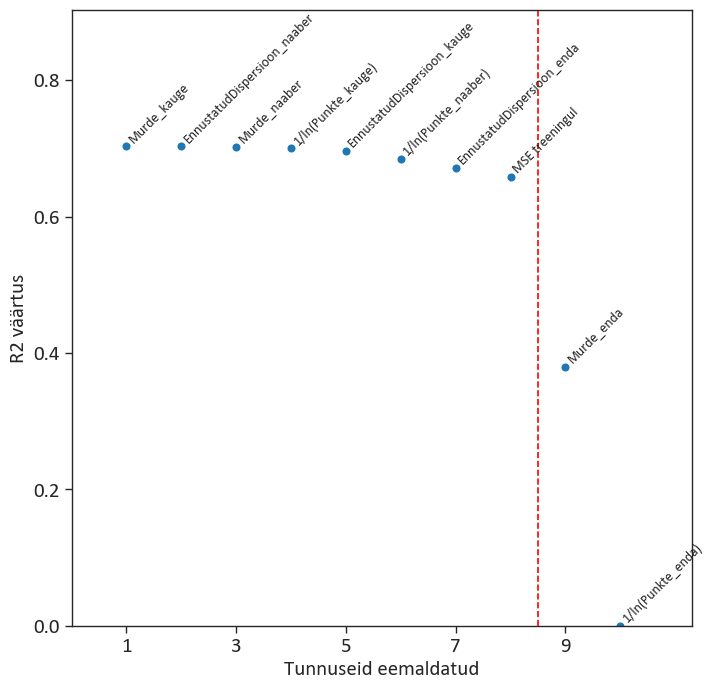

In [85]:
# plt.figure(figsize=(5,5))
# plt.plot(np.arange(1, len(resulting_r2s)+1), resulting_r2s, "o",)
# plt.xlabel("Tunnuseid dropitud")
# plt.ylabel("r2 väärtus")
print("Tunnused enne langust:", parimad_subsetid[7])


plt.vlines(x=8.5, ymin=0, ymax=max(resulting_r2s)+0.2, linestyles='--', color="r")
plt.plot(range(1, len(resulting_r2s)+1), resulting_r2s, "o")

for i, feature_name in enumerate(removed_features, start=1):
    plt.annotate(feature_name, (i, resulting_r2s[i-1]+0.001), fontsize=10, rotation=45, ha='left', va='bottom')#,  textcoords='offset pixels')



plt.xticks(range(1, len(resulting_r2s)+1, 2))
plt.ylim(0, max(resulting_r2s)+0.2)
plt.xlim(0, len(resulting_r2s)+1.3)


In [74]:
model = mudelid[7]
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     7769.
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        17:02:20   Log-Likelihood:                 8215.1
No. Observations:                8050   AIC:                        -1.642e+04
Df Residuals:                    8047   BIC:                        -1.640e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Konstant              0.1289      0.002     61.618      0.000       0.125       0.133
Murde_enda           -0.3989      0.005    -81.102      0.000      -0.409      -0.389
1/ln(Punkte_enda)    -0.8832      0.009    -98.565      0.000      -0.901      -0.866
==============================================================================
Omnibus:                     3090.085   Durbin-Watson:                   0.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           280370.704
Skew:                           0.909   Prob(JB):                         0.00
Kurtosis:                      31.854   Cond. No.                         9.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Siit alla on omalooming
### kombineerime nagu enne logm1 omavahel kokku

In [122]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

suurX = suurX[[col for col in suurX.columns if col.endswith("points_logm1") ]]
suurX = muuda_veergude_nimed_eestikeelseks(suurX)
uuritavad_col = suurX.columns

# tegelikult ei pea skaleerima sest m1 on nkn juba pmst 0..1 vahemikus
points_scaler = MinMaxScaler()
suurX = points_scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)

points_result, points_newX, newy = treeni_ols(suurX, suury)

summary_table = pd.read_html(points_result.summary().as_html(), header=0, index_col=0)
with pd.ExcelWriter(r"plots3\kirjalik_osa\kaalud_punktide_kombineerimiseks.xlsx", engine='openpyxl') as writer:
    summary_table[1].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)


points_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     1829.
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        23:12:37   Log-Likelihood:                 5979.6
No. Observations:                8050   AIC:                        -1.195e+04
Df Residuals:                    8046   BIC:                        -1.192e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
1/ln(Punkte_enda)      -0.4962      0.022    -22.271      0.000      -0.540      -0.453
1/ln(Punkte_naaber)    -0.2664      0.026    -10.405      0.000      -0.317      -0.216
1/ln(Punkte_kauge)     -0.1830      0.023     -7.847      0.000      -0.229      -0.137
Konstant                0.0496      0.002     20.373      0.000       0.045       0.054
==============================================================================
Omnibus:                     2580.990   Durbin-Watson:                   0.556
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            41173.129
Skew:                          -1.105   Prob(JB):                         0.00
Kurtosis:                      13.857   Cond. No.                         24.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Kombineerime bpoints kokku

In [123]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

suurX = suurX[[col for col in suurX.columns if "bpoint" in col]]
suurX = muuda_veergude_nimed_eestikeelseks(suurX)
uuritavad_col = suurX.columns
bpoint_scaler = MinMaxScaler()
suurX = bpoint_scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)

suury = suury - points_result.predict(points_newX)

bpoints_result, bpoints_newX, newy = treeni_ols(suurX, suury)

summary_table = pd.read_html(bpoints_result.summary().as_html(), header=0, index_col=0)
with pd.ExcelWriter(r"plots3\kirjalik_osa\kaalud_murdepunktide_kombineerimiseks.xlsx", engine='openpyxl') as writer:
    summary_table[1].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)

bpoints_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     2288.
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        23:12:42   Log-Likelihood:                 8462.1
No. Observations:                8050   AIC:                        -1.692e+04
Df Residuals:                    8046   BIC:                        -1.689e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Murde_enda      -0.3759      0.005    -71.718      0.000      -0.386      -0.366
Murde_naaber    -0.0598      0.006    -10.443      0.000      -0.071      -0.049
Murde_kauge     -0.0245      0.006     -4.343      0.000      -0.036      -0.013
Konstant         0.1122      0.003     32.522      0.000       0.105       0.119
==============================================================================
Omnibus:                     1939.512   Durbin-Watson:                   0.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           116292.435
Skew:                           0.142   Prob(JB):                         0.00
Kurtosis:                      21.618   Cond. No.                         8.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Nüüd on kombineeritud asjad olemas, saame nad panna suurde mudelisse ja vaadata kas nad jäävad alles

In [149]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

suurX["points_combo"] = kombineeri_tunnus_mudelist_ja_dfist(points_result, points_newX) # ei ole skaleeritud
suurX["bpoints_combo"] = kombineeri_tunnus_mudelist_ja_dfist(bpoints_result, bpoints_newX) # pmst eelnevalt skaleeritud

suurX = suurX[[col for col in suurX.columns if col in alati_ok or "combo" in col ]]


uuritavad_col = suurX.columns
general_scaler = MinMaxScaler()
suurX = general_scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
suurX = sm.add_constant(suurX)
suurX = muuda_veergude_nimed_eestikeelseks(suurX)

resulting_r2s = []
parimad_subsetid = []
mudelid = []
removed_features = []
while len(suurX.columns) > 1:
    best_r2, best_subset, result = backward_stepwise_regression(suurX, suury)
    significant = [p_value < 0.05 for p_value in result.pvalues]
    if all(significant):
        print("kõik on olulised")
    print("Best subset of predictor variables:", best_subset)
    removed_features.append(list(set(suurX.columns) - set(best_subset))[0])
    print("Removed predictor variables:", removed_features[-1])
    print("Best R² score:", best_r2)
    print()
    suurX = suurX[best_subset]
    resulting_r2s.append(best_r2)
    parimad_subsetid.append(best_subset)
    mudelid.append(result)

Best subset of predictor variables: ['Konstant', 'Murde_naaber', 'Murde_kauge', 'EnnustatudDispersioon_enda', 'EnnustatudDispersioon_naaber', 'EnnustatudDispersioon_kauge', 'MSE treeningul', 'Punkte_kombi', 'Murde_kombi']
Removed predictor variables: Murde_enda
Best R² score: 0.7019160287363404

kõik on olulised
Best subset of predictor variables: ['Konstant', 'Murde_naaber', 'Murde_kauge', 'EnnustatudDispersioon_enda', 'EnnustatudDispersioon_kauge', 'MSE treeningul', 'Punkte_kombi', 'Murde_kombi']
Removed predictor variables: EnnustatudDispersioon_naaber
Best R² score: 0.7018400794986686

kõik on olulised
Best subset of predictor variables: ['Konstant', 'Murde_naaber', 'EnnustatudDispersioon_enda', 'EnnustatudDispersioon_kauge', 'MSE treeningul', 'Punkte_kombi', 'Murde_kombi']
Removed predictor variables: Murde_kauge
Best R² score: 0.7016349619592399

kõik on olulised
Best subset of predictor variables: ['Konstant', 'EnnustatudDispersioon_enda', 'EnnustatudDispersioon_kauge', 'MSE tre

Tunnused enne langust: ['Konstant', 'MSE treeningul', 'Punkte_kombi', 'Murde_kombi']


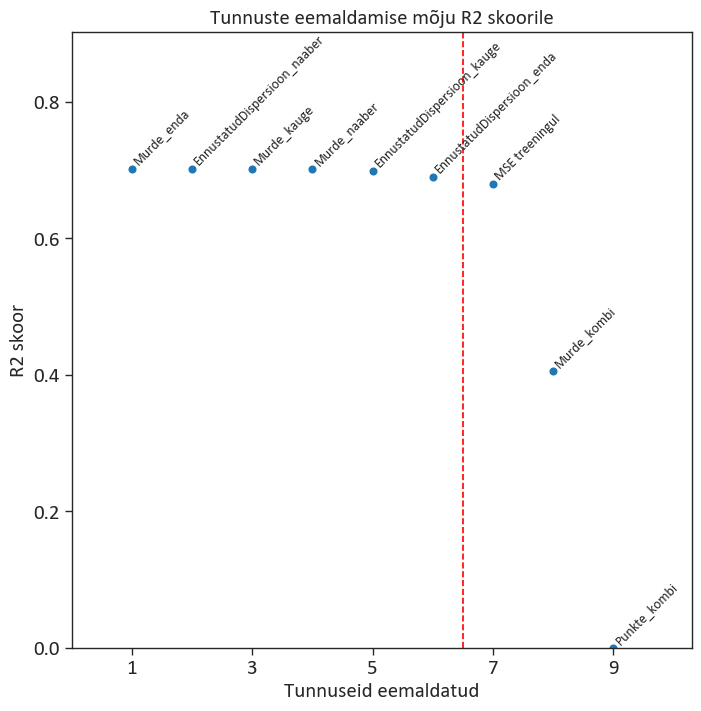

In [151]:
# plt.figure(figsize=(5,5))
# plt.plot(np.arange(1, len(resulting_r2s)+1), resulting_r2s, "o",)
# plt.xlabel("Tunnuseid dropitud")
# plt.ylabel("r2 väärtus")
# print("Tunnused enne langust:", parimad_subsetid[3])
# print("Selle r2 oli", resulting_r2s[3])

plt.vlines(x=6.5, ymin=0, ymax=max(resulting_r2s)+0.2, linestyles='--', color="r")
plt.plot(range(1, len(resulting_r2s)+1), resulting_r2s, "o")

for i, feature_name in enumerate(removed_features, start=1):
    # plt.annotate(feature_name, (i+0.5, resulting_r2s[i-1]+ 0.002), fontsize=10, ha='center', va='bottom', rotation=60)
    plt.annotate(feature_name, (i, resulting_r2s[i-1]+0.001), fontsize=10, rotation=45, ha='left', va='bottom')#,  textcoords='offset pixels')


plt.xlabel("Tunnuseid eemaldatud")
plt.ylabel("R2 skoor")
plt.title("Tunnuste eemaldamise mõju R2 skoorile")
plt.xticks(range(1, 20, 2))
plt.ylim(0, max(resulting_r2s)+0.2)
plt.xlim(0, len(resulting_r2s)+1.3)
print("Tunnused enne langust:", parimad_subsetid[5])
plt.savefig("plots3/kirjalik_osa/ols_backward_stepwise_kombid.png", bbox_inches='tight')

In [127]:
mudelid[5].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     5974.
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        23:13:12   Log-Likelihood:                 8603.4
No. Observations:                8050   AIC:                        -1.720e+04
Df Residuals:                    8046   BIC:                        -1.717e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Konstant          -0.9142      0.007   -135.215      0.000      -0.927      -0.901
MSE treeningul    -0.0725      0.004    -16.276      0.000      -0.081      -0.064
Punkte_kombi       0.6786      0.007    102.712      0.000       0.666       0.692
Murde_kombi        0.4059      0.005     84.548      0.000       0.396       0.415
==============================================================================
Omnibus:                     2259.219   Durbin-Watson:                   0.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           145153.225
Skew:                           0.459   Prob(JB):                         0.00
Kurtosis:                      23.783   Cond. No.                         15.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### kuna paar featurid dropiti, ei sobi see hetke general scaler, peame uuesti tegema

In [128]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

suurX["points_combo"] = kombineeri_tunnus_mudelist_ja_dfist(points_result, points_newX) # 
suurX["bpoints_combo"] = kombineeri_tunnus_mudelist_ja_dfist(bpoints_result, bpoints_newX) # pmst eelnevalt skaleeritud
suurX = muuda_veergude_nimed_eestikeelseks(suurX)

general_scaler = MinMaxScaler()
uuritavad_col = parimad_subsetid[5].copy()

if "const" in uuritavad_col:
    uuritavad_col.remove("const")
elif "Konstant" in uuritavad_col:
    uuritavad_col.remove("Konstant")


suurX =general_scaler.fit_transform(suurX[uuritavad_col])
suurX = pd.DataFrame(suurX, columns=uuritavad_col)

result_kuuega, newX, newy = treeni_ols(suurX, suury)

summary_table = pd.read_html(result_kuuega.summary().as_html(), header=0, index_col=0)
with pd.ExcelWriter(r"plots3\kirjalik_osa\lopliku_mudeli_kaalud.xlsx", engine='openpyxl') as writer:
    summary_table[1].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)

result_kuuega.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     5974.
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        23:13:15   Log-Likelihood:                 8603.4
No. Observations:                8050   AIC:                        -1.720e+04
Df Residuals:                    8046   BIC:                        -1.717e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
MSE treeningul    -0.0725      0.004    -16.276      0.000      -0.081      -0.064
Punkte_kombi       0.6786      0.007    102.712      0.000       0.666       0.692
Murde_kombi        0.4059      0.005     84.548      0.000       0.396       0.415
Konstant          -0.9142      0.007   -135.215      0.000      -0.927      -0.901
==============================================================================
Omnibus:                     2259.219   Durbin-Watson:                   0.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           145153.225
Skew:                           0.459   Prob(JB):                         0.00
Kurtosis:                      23.783   Cond. No.                         15.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [118]:
mudelid[5].mse_model

41.28000015961203

In [119]:
mudelid[5].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     5974.
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        23:12:01   Log-Likelihood:                 8603.4
No. Observations:                8050   AIC:                        -1.720e+04
Df Residuals:                    8046   BIC:                        -1.717e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Konstant          -0.9142      0.007   -135.215      0.000      -0.927      -0.901
MSE treeningul    -0.0725      0.004    -16.276      0.000      -0.081      -0.064
Punkte_kombi       0.6786      0.007    102.712      0.000       0.666       0.692
Murde_kombi        0.4059      0.005     84.548      0.000       0.396       0.415
==============================================================================
Omnibus:                     2259.219   Durbin-Watson:                   0.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           145153.225
Skew:                           0.459   Prob(JB):                         0.00
Kurtosis:                      23.783   Cond. No.                         15.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [129]:
general_scaler
points_scaler
points_result
bpoint_scaler
bpoints_result
final_model = mudelid[5]

In [130]:
general_scaler.feature_names_in_

array(['MSE treeningul', 'Punkte_kombi', 'Murde_kombi'], dtype=object)

In [131]:
import pickle

final_model = mudelid[5]

with open('ols_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)
with open('points_model.pkl', 'wb') as f:
    pickle.dump(points_result, f)
with open('bpoints_model.pkl', 'wb') as f:
    pickle.dump(bpoints_result, f)

with open('general_scaler.pkl', 'wb') as f:
    pickle.dump(general_scaler, f)
with open('points_scaler.pkl', 'wb') as f:
    pickle.dump(points_scaler, f)
with open('bpoint_scaler.pkl', 'wb') as f:
    pickle.dump(bpoint_scaler, f)

# Üritame leida algsele asjale kaalud

In [137]:
import pickle

with open('ols_model.pkl', 'rb') as f:
    final_model = pickle.load(f)
with open('points_model.pkl', 'rb') as f:
    points_result = pickle.load(f)
with open('bpoints_model.pkl', 'rb') as f:
    bpoints_result = pickle.load(f)

with open('general_scaler.pkl', 'rb') as f:
    general_scaler = pickle.load(f)
with open('points_scaler.pkl', 'rb') as f:
    points_scaler = pickle.load(f)
with open('bpoint_scaler.pkl', 'rb') as f:
    bpoint_scaler = pickle.load(f)

In [139]:
Xid, yid = loe_andmed_uuesti()
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

suurX = muuda_veergude_nimed_eestikeelseks(suurX)

In [140]:
suurX.head()

Murde_enda  Murde_naaber  Murde_kauge  EnnustatudDispersioon_enda  \
0   10.750000      5.500000     1.500000                    0.436153   
1    7.150000      5.350000     0.900000                    0.144877   
2    7.862069      5.827586     1.413793                    0.166600   
3    8.511628      4.767442     1.372093                    0.169703   
4    9.972222      3.583333     0.916667                    0.191265   

   EnnustatudDispersioon_naaber  EnnustatudDispersioon_kauge  Punkte_enda  \
0                      0.573000                     1.074436          1.0   
1                      0.682587                     1.357466          2.0   
2                      0.749506                     1.425814          2.0   
3                      0.818364                     1.555484          3.0   
4                      0.882617                     1.459296          3.0   

   Punkte_naaber  Punkte_kauge  1/Punkte_enda  ln(Punkte_enda)  \
0            3.0           3.0       1.000000         0.000000   
1            5.0           5.0       0.500000         0.693147   
2            7.0           7.0       0.500000         0.693147   
3            9.0           9.0       0.333333         1.098612   
4           11.0          11.0       0.333333         1.098612   

   1/ln(Punkte_enda)  1/Punkte_naaber  ln(Punkte_naaber)  1/ln(Punkte_naaber)  \
0           1.000000         0.333333           1.098612             0.476505   
1           0.590616         0.200000           1.609438             0.383224   
2           0.590616         0.142857           1.945910             0.339454   
3           0.476505         0.111111           2.197225             0.312771   
4           0.476505         0.090909           2.397895             0.294300   

   1/Punkte_kauge  ln(Punkte_kauge)  1/ln(Punkte_kauge)  MSE treeningul  
0        0.333333          1.098612            0.476505        2.849730  
1        0.200000          1.609438            0.383224        2.792928  
2        0.142857          1.945910            0.339454        3.449995  
3        0.111111          2.197225            0.312771        3.295096  
4        0.090909          2.397895            0.294300        3.410475

In [135]:
for model in [final_model, points_result, bpoints_result]:
    print(model.params.keys().values)
    print(model.params.values)
    print()

['Konstant' 'MSE treeningul' 'Punkte_kombi' 'Murde_kombi']
[-0.91416815 -0.0724682   0.67860921  0.40585455]

['1/ln(Punkte_enda)' '1/ln(Punkte_naaber)' '1/ln(Punkte_kauge)' 'Konstant']
[-0.49621769 -0.26642053 -0.18302744  0.04956302]

['Murde_enda' 'Murde_naaber' 'Murde_kauge' 'Konstant']
[-0.37588743 -0.05977202 -0.02452053  0.11216481]



In [ ]:
uued_parameetrid = {}
for a,b in final_model.params.items():
    print(a, end="\t")
    print(b)
    uued_parameetrid[a] = b
print()
for a,b in points_result.params.items():
    print(a, end="\t")
    print(b * final_model.params["Punkte_kombi"])
    if a in uued_parameetrid:
        uued_parameetrid[a] += b * final_model.params["Punkte_kombi"]
    else:
        uued_parameetrid[a] = b * final_model.params["Punkte_kombi"]
print()
for a,b in bpoints_result.params.items():
    print(a, end="\t")
    print(b*final_model.params["Murde_kombi"])
    if a in uued_parameetrid:
        uued_parameetrid[a] += b * final_model.params["Murde_kombi"]
    else:
        uued_parameetrid[a] = b * final_model.params["Murde_kombi"]

del uued_parameetrid["Punkte_kombi"]
del uued_parameetrid["Murde_kombi"]
uued_parameetrid
params = np.asanyarray(list(uued_parameetrid.values()))

Konstant	-2.589523631110943
EnnustatudDispersioon_enda	4.384575837482528
EnnustatudDispersioon_naaber	3.641714794706273
MSE treeningul	-1.6358382216379186
Punkte_kombi	0.7570389880769328
Murde_kombi	2.938841020023612

1/Punkte_enda	-0.6881206068126772
1/Punkte_naaber	-0.3863127521170152
1/Punkte_kauge	-0.3704559311810649
Konstant	0.196987464848774

Murde_enda	1.8495808774600508
Murde_naaber	1.2703150192525108
Murde_kauge	0.5517393481983258
Konstant	-1.0354957656916024


In [148]:
suurX = pd.concat(Xid, ignore_index=True)

suurX = muuda_veergude_nimed_eestikeelseks(suurX)

suurX["Konstant"] = 1
suurX[points_scaler.feature_names_in_] = points_scaler.transform(suurX[points_scaler.feature_names_in_])
suurX["Punkte_kombi"] = kombineeri_tunnus_mudelist_ja_dfist(points_result, suurX)
suurX[bpoint_scaler.feature_names_in_] = bpoint_scaler.transform(suurX[bpoint_scaler.feature_names_in_])
suurX["Murde_kombi"] = kombineeri_tunnus_mudelist_ja_dfist(bpoints_result, suurX)


uuritavad_col = general_scaler.feature_names_in_
suurX = suurX[uuritavad_col]
suurX = general_scaler.transform(suurX)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
suurX["Konstant"] = 1

final_model.predict(suurX)

0       0.392665
1       0.537780
2       0.460643
3       0.443534
4       0.386883
          ...   
8045    0.766070
8046    0.723654
8047    0.699725
8048    0.690889
8049    0.625485
Length: 8050, dtype: float64

In [147]:
suurX

MSE treeningul  Punkte_kombi  Murde_kombi
0           0.126578      0.000000     0.151080
1           0.123505      0.417569     0.405373
2           0.159057      0.451089     0.343176
3           0.150675      0.568003     0.319160
4           0.156918      0.582148     0.245598
...              ...           ...          ...
8045        0.077085      0.920995     0.733010
8046        0.085277      0.953137     0.684972
8047        0.083123      0.968863     0.648490
8048        0.084529      0.978910     0.638435
8049        0.084069      1.000000     0.543688

[8050 rows x 3 columns]

In [ ]:
suurX = muuda_veergude_nimed_eestikeelseks(suurX)
suurX["Konstant"] = 1
tempX = suurX[list(uued_parameetrid.keys())]
tempX.loc[:,bpoint_scaler.get_feature_names_out()] = bpoint_scaler.transform(tempX[bpoint_scaler.get_feature_names_out()])
tempX.loc[:,points_scaler.get_feature_names_out()] = points_scaler.transform(tempX[points_scaler.get_feature_names_out()])
tempX.loc[:,general_scaler.get_feature_names_out()[:-2]] = (tempX[general_scaler.get_feature_names_out()[:-2]] - general_scaler.data_min_[:-2]) / (general_scaler.data_max_[:-2] - general_scaler.data_min_[:-2])
tempX

C:\Users\troosma\AppData\Local\Temp\ipykernel_16496\3494751670.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempX.loc[:,bpoint_scaler.get_feature_names_out()] = bpoint_scaler.transform(tempX[bpoint_scaler.get_feature_names_out()])
C:\Users\troosma\AppData\Local\Temp\ipykernel_16496\3494751670.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempX.loc[:,points_scaler.get_feature_names_out()] = points_scaler.transform(tempX[points_scaler.get_feature_names_out()])
C:\Users\troosma\AppData\Local\Temp\

Konstant  EnnustatudDispersioon_enda  EnnustatudDispersioon_naaber  \
0            1                    0.030495                      0.045846   
1            1                    0.008435                      0.060346   
2            1                    0.010080                      0.069200   
3            1                    0.010315                      0.078310   
4            1                    0.011948                      0.086812   
...        ...                         ...                           ...   
8045         1                    0.037372                      0.095933   
8046         1                    0.034639                      0.098275   
8047         1                    0.034308                      0.098751   
8048         1                    0.033590                      0.096345   
8049         1                    0.033009                      0.097085   

      MSE treeningul  1/Punkte_enda  1/Punkte_naaber  1/Punkte_kauge  \
0           0.109560       1.000000         0.332917        0.332917   
1           0.106427       0.499688         0.199500        0.199500   
2           0.142671       0.499688         0.142321        0.142321   
3           0.134127       0.332917         0.110556        0.110556   
4           0.140491       0.332917         0.090341        0.090341   
...              ...            ...              ...             ...   
8045        0.059227       0.004353         0.018995        0.018995   
8046        0.067124       0.001870         0.009282        0.009282   
8047        0.065648       0.001040         0.006002        0.006002   
8048        0.066509       0.000624         0.004353        0.004353   
8049        0.066141       0.000000         0.001870        0.001870   

      Murde_enda  Murde_naaber  Murde_kauge  
0       0.790441      0.703325     0.214286  
1       0.525735      0.684143     0.128571  
2       0.578093      0.745216     0.201970  
3       0.625855      0.609647     0.196013  
4       0.733252      0.458227     0.130952  
...          ...           ...          ...  
8045    0.229412      0.232737     0.414286  
8046    0.272059      0.260870     0.391429  
8047    0.297059      0.329923     0.368571  
8048    0.329412      0.289003     0.385714  
8049    0.414706      0.360614     0.422857  

[8050 rows x 10 columns]

In [136]:
general_scaler.get_feature_names_out()

array(['MSE treeningul', 'Punkte_kombi', 'Murde_kombi'], dtype=object)

In [ ]:
residuals = suury - np.dot(tempX, params) # Calculate the residuals
n, k = tempX.shape
sigma2 = np.dot(residuals, residuals) / (n - k) # Calculate the error variance (sigma^2)
XtX_inv = np.linalg.inv(np.dot(tempX.T, tempX)) # Calculate the inverse of X'X
cov_params = sigma2 * XtX_inv # Calculate the covariance matrix of the parameters
cov_params

array([[ 1.28563230e-02, -1.03419549e-02, -1.22273028e-02,
         1.08222286e-03,  3.92452912e-05, -3.88991829e-03,
        -4.32522473e-03, -5.76829906e-03, -1.06774074e-02,
        -9.64142121e-03],
       [-1.03419549e-02,  1.44032532e-01, -9.00796718e-02,
        -3.63519284e-03, -2.31133996e-03, -5.04265677e-04,
         7.60331990e-03,  1.34153114e-02,  6.76143188e-03,
         1.13107468e-02],
       [-1.22273028e-02, -9.00796718e-02,  1.30147120e-01,
        -9.58581634e-03,  1.77408977e-03,  4.24579471e-03,
        -4.35869514e-03,  1.40016915e-03,  9.66545569e-03,
        -6.12493043e-03],
       [ 1.08222286e-03, -3.63519284e-03, -9.58581634e-03,
         1.16523923e-02, -5.49334294e-04, -1.67337684e-03,
        -1.34228372e-03, -1.86369642e-03, -2.27593703e-03,
        -5.57372036e-04],
       [ 3.92452912e-05, -2.31133996e-03,  1.77408977e-03,
        -5.49334294e-04,  1.17283373e-01, -6.26603266e-02,
        -4.26846504e-02,  3.06904036e-03, -3.52391146e-03,
        -1.

In [ ]:
result = sm.OLS(suury, tempX[list(uued_parameetrid.keys())]).fit(start_params=[uued_parameetrid.values()], maxiter=0)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     754.5
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        08:55:59   Log-Likelihood:                -8203.3
No. Observations:                8050   AIC:                         1.643e+04
Df Residuals:                    8040   BIC:                         1.650e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Konstant                        -1.9605      0.040    -48.491      0.000      -2.040      -1.881
EnnustatudDispersioon_enda       4.3063      0.135     31.822      0.000       4.041       4.572
EnnustatudDispersioon_naaber     3.8440      0.129     29.883      0.000       3.592       4.096
MSE treeningul                  -1.6573      0.038    -43.058      0.000      -1.733      -1.582
1/Punkte_enda                   -0.8589      0.122     -7.033      0.000      -1.098      -0.619
1/Punkte_naaber                 -0.0746      0.143     -0.523      0.601      -0.354       0.205
1/Punkte_kauge                  -0.1537      0.129     -1.194      0.233      -0.406       0.099
Murde_enda                       1.8959      0.046     41.644      0.000       1.807       1.985
Murde_naaber                     1.8659      0.050     37.345      0.000       1.768       1.964
Murde_kauge                      0.6258      0.047     13.357      0.000       0.534       0.718
==============================================================================
Omnibus:                     3145.033   Durbin-Watson:                   0.269
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15632.304
Skew:                           1.839   Prob(JB):                         0.00
Kurtosis:                       8.752   Cond. No.                         27.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [104]:
for a,b in zip(result.params.items(), uued_parameetrid.items()):
    print(a, end="\t")
    print(b)

NameError: name 'uued_parameetrid' is not defined

In [ ]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     754.5
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        08:56:01   Log-Likelihood:                -8203.3
No. Observations:                8050   AIC:                         1.643e+04
Df Residuals:                    8040   BIC:                         1.650e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Konstant                        -1.9605      0.040    -48.491      0.000      -2.040      -1.881
EnnustatudDispersioon_enda       4.3063      0.135     31.822      0.000       4.041       4.572
EnnustatudDispersioon_naaber     3.8440      0.129     29.883      0.000       3.592       4.096
MSE treeningul                  -1.6573      0.038    -43.058      0.000      -1.733      -1.582
1/Punkte_enda                   -0.8589      0.122     -7.033      0.000      -1.098      -0.619
1/Punkte_naaber                 -0.0746      0.143     -0.523      0.601      -0.354       0.205
1/Punkte_kauge                  -0.1537      0.129     -1.194      0.233      -0.406       0.099
Murde_enda                       1.8959      0.046     41.644      0.000       1.807       1.985
Murde_naaber                     1.8659      0.050     37.345      0.000       1.768       1.964
Murde_kauge                      0.6258      0.047     13.357      0.000       0.534       0.718
==============================================================================
Omnibus:                     3145.033   Durbin-Watson:                   0.269
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15632.304
Skew:                           1.839   Prob(JB):                         0.00
Kurtosis:                       8.752   Cond. No.                         27.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
for sc in [general_scaler, points_scaler, bpoint_scaler]:
    print(sc.get_feature_names_out())
    print(sc.data_max_)
    print(sc.data_min_)
    print()

['EnnustatudDispersioon_enda' 'EnnustatudDispersioon_naaber'
 'MSE treeningul' 'Punkte_kombi' 'Murde_kombi']
[13.23775702  7.78445639 18.99221882  0.25833816  0.51619568]
[ 0.03349581  0.22649769  0.86355516 -0.98155321 -0.34162032]

['1/Punkte_enda' '1/Punkte_naaber' '1/Punkte_kauge']
[1. 1. 1.]
[0.00062461 0.00062461 0.00062461]

['Murde_enda' 'Murde_naaber' 'Murde_kauge']
[13.6   7.82  7.  ]
[0. 0. 0.]



In [ ]:
5/0

# Vana asi

# Teeme alumisele ruudule tunnused eraldi analüüsi kokku
## Mypoints kokku

In [ ]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)
suurX = suurX[[col for col in suurX.columns if "my_points" in col]]

uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result1, newX, newy = treeni_ols(suurX, suury)

summary_table = pd.read_html(result1.summary().as_html(), header=0, index_col=0)
with pd.ExcelWriter(r"plots3\kirjalik_osa\minu_punktid_kaalud.xlsx", engine='openpyxl') as writer:
    summary_table[1].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     98.45
Date:                Mon, 08 May 2023   Prob (F-statistic):           6.16e-82
Time:                        08:56:05   Log-Likelihood:                -10475.
No. Observations:                8050   AIC:                         2.096e+04
Df Residuals:                    8045   BIC:                         2.100e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
my_points          -0.7009      0.215     -3.260      0.001      -1.122      -0.279
my_points_m1       -3.9293      1.711     -2.297      0.022      -7.283      -0.576
my_points_log       2.3260      0.555      4.193      0.000       1.239       3.413
my_points_logm1     5.0711      2.325      2.181      0.029       0.513       9.629
Konstant           -1.3947      0.481     -2.902      0.004      -2.337      -0.453
==============================================================================
Omnibus:                     3810.992   Durbin-Watson:                   0.138
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19525.006
Skew:                           2.306   Prob(JB):                         0.00
Kurtosis:                       9.078   Cond. No.                         333.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
punktide_arv = np.arange(2, 1600)
poord_punktid = 1/punktide_arv
log_punktid = np.log(punktide_arv)
poord_log_punktid = 1/np.log(punktide_arv)
const = np.ones(shape=punktide_arv.shape) 

def minimax(X): return (X-np.min(X)) / (np.max(X)-np.min(X))
punktide_arv = minimax(punktide_arv)
poord_punktid = minimax(poord_punktid)
log_punktid = minimax(log_punktid)
poord_log_punktid = minimax(poord_log_punktid)

# y1 = kombineeri_tunnus_mudelist_ja_dfist(result1, newX)
y1 = punktide_arv * result1.params["my_points"] + poord_punktid * result1.params["my_points_m1"] + log_punktid * result1.params["my_points_log"] + poord_log_punktid * result1.params["my_points_logm1"] + const * result1.params["const"]
sns.lineplot(x=punktide_arv, y=y1)
# y1 = poord_log_punktid * result1.params["my_points_logm1"] + const * result1.params["const"]
# sns.lineplot(x=punktide_arv, y=y1)

KeyError: 'const'

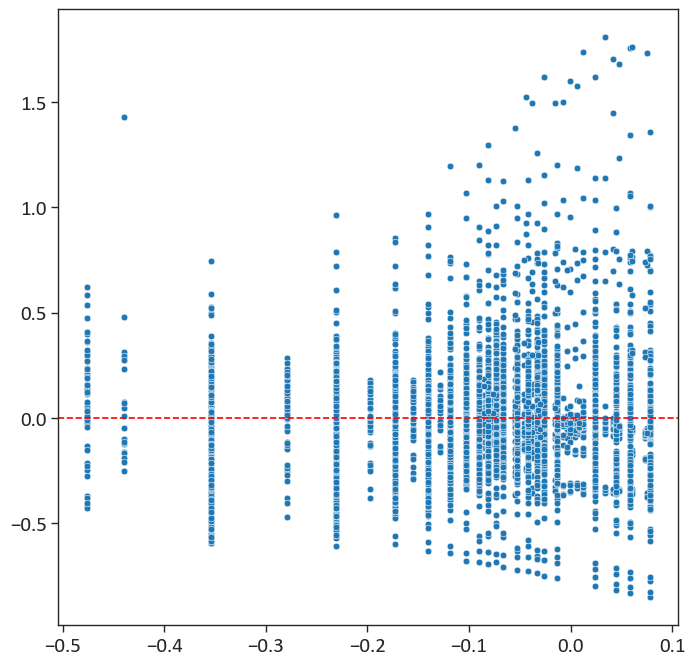

In [ ]:
residuals = newy - result1.predict(newX)
sns.scatterplot(x=result1.predict(newX), y=residuals)
plt.axhline(y=0, color='r', linestyle='--')

## Neighbour punktid kokku

In [ ]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)
suurX = suurX[[col for col in suurX.columns if "neighbour_points" in col]]

uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result2, newX, newy = treeni_ols(suurX, suury)

summary_table = pd.read_html(result2.summary().as_html(), header=0, index_col=0)
with pd.ExcelWriter(r"plots3\kirjalik_osa\naaber_punktid_kaalud.xlsx", engine='openpyxl') as writer:
    summary_table[1].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)
    
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     393.9
Date:                Fri, 05 May 2023   Prob (F-statistic):          2.81e-310
Time:                        11:21:40   Log-Likelihood:                 413.99
No. Observations:                8030   AIC:                            -818.0
Df Residuals:                    8025   BIC:                            -783.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.5441      0.172     -3.168      0.002      -0.881      -0.207
neighbour_points          -0.3268      0.071     -4.623      0.000      -0.465      -0.188
neighbour_points_m1       -1.7966      0.568     -3.163      0.002      -2.910      -0.683
neighbour_points_log       0.7729      0.202      3.835      0.000       0.378       1.168
neighbour_points_logm1     1.7054      0.802      2.126      0.034       0.133       3.278
==============================================================================
Omnibus:                     3121.577   Durbin-Watson:                   0.172
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34990.234
Skew:                           1.543   Prob(JB):                         0.00
Kurtosis:                      12.750   Cond. No.                         440.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot: >

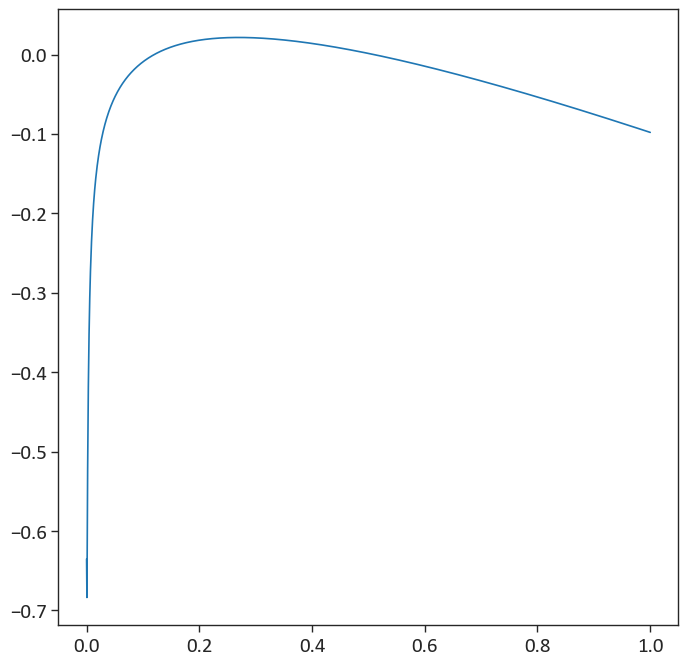

In [ ]:
punktide_arv = np.arange(2, 1600)
poord_punktid = 1/punktide_arv
log_punktid = np.log(punktide_arv)
poord_log_punktid = 1/np.log(punktide_arv)
const = np.ones(shape=punktide_arv.shape) 

def minimax(X): return (X-np.min(X)) / (np.max(X)-np.min(X))
punktide_arv = minimax(punktide_arv)
poord_punktid = minimax(poord_punktid)
log_punktid = minimax(log_punktid)
poord_log_punktid = minimax(poord_log_punktid)

y2 = punktide_arv * result2.params["neighbour_points"] + poord_punktid * result2.params["neighbour_points_m1"] + log_punktid * result2.params["neighbour_points_log"] + poord_log_punktid * result2.params["neighbour_points_logm1"] + const*result2.params["const"]
sns.lineplot(x=punktide_arv, y=y2)
# y2 = poord_log_punktid * result2.params["neighbour_points_logm1"] + const*result2.params["const"]
# sns.lineplot(x=punktide_arv, y=y2)

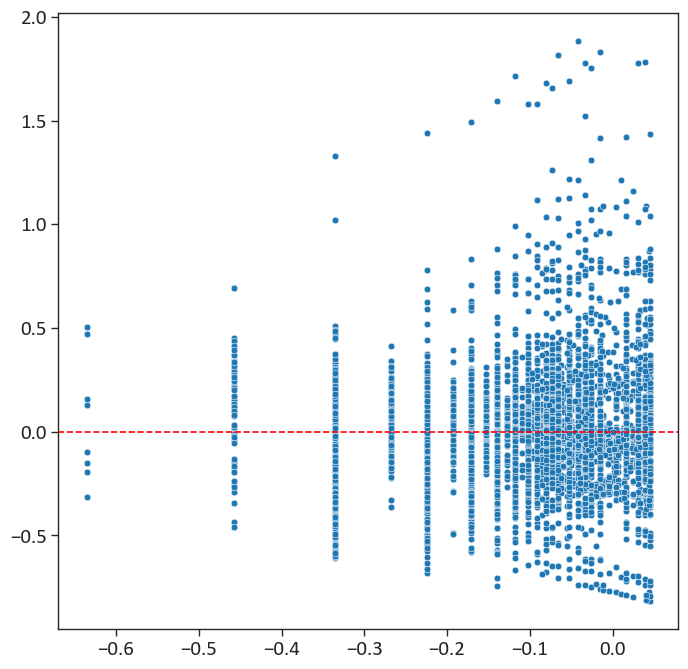

In [ ]:
residuals = newy - result2.predict(newX)
sns.scatterplot(x=result2.predict(newX), y=residuals)
plt.axhline(y=0, color='r', linestyle='--')

## Distant

In [ ]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)
suurX = suurX[[col for col in suurX.columns if "distant_points" in col]]

uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result3, newX, newy = treeni_ols(suurX, suury)

summary_table = pd.read_html(result3.summary().as_html(), header=0, index_col=0)
with pd.ExcelWriter(r"plots3\kirjalik_osa\kauge_punktid_kaalud.xlsx", engine='openpyxl') as writer:
    summary_table[1].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)

result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     349.8
Date:                Fri, 05 May 2023   Prob (F-statistic):          5.10e-278
Time:                        11:21:49   Log-Likelihood:                 339.56
No. Observations:                8030   AIC:                            -669.1
Df Residuals:                    8025   BIC:                            -634.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.8007      0.135     -5.923      0.000      -1.066      -0.536
distant_points          -0.3591      0.060     -6.015      0.000      -0.476      -0.242
distant_points_m1       -2.6190      0.472     -5.552      0.000      -3.544      -1.694
distant_points_log       1.0570      0.157      6.742      0.000       0.750       1.364
distant_points_logm1     2.9404      0.648      4.539      0.000       1.671       4.210
==============================================================================
Omnibus:                     3107.521   Durbin-Watson:                   0.169
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33748.044
Skew:                           1.544   Prob(JB):                         0.00
Kurtosis:                      12.557   Cond. No.                         354.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot: >

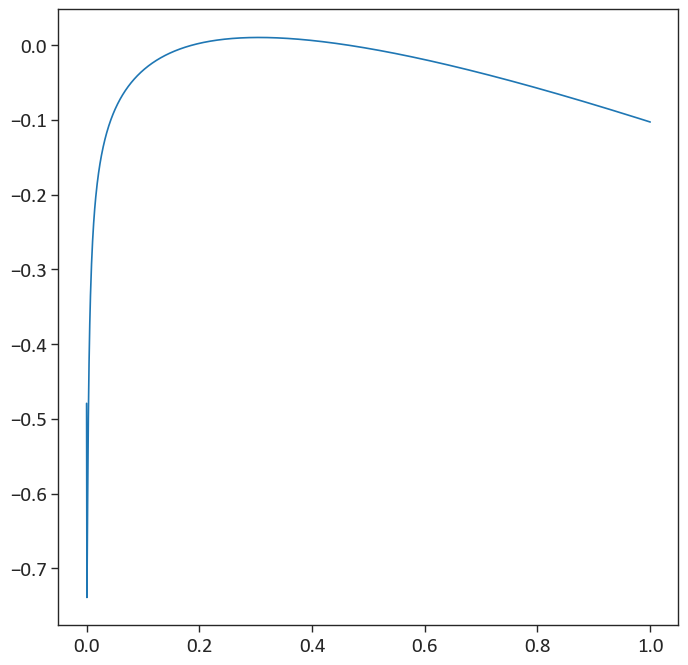

In [ ]:
punktide_arv = np.arange(2, 1600)
poord_punktid = 1/punktide_arv
log_punktid = np.log(punktide_arv)
poord_log_punktid = 1/np.log(punktide_arv)
const = np.ones(shape=punktide_arv.shape)

def minimax(X): return (X-np.min(X)) / (np.max(X)-np.min(X))
punktide_arv = minimax(punktide_arv)
poord_punktid = minimax(poord_punktid)
log_punktid = minimax(log_punktid)
poord_log_punktid = minimax(poord_log_punktid)

y3 = punktide_arv * result3.params["distant_points"] + poord_punktid * result3.params["distant_points_m1"] + log_punktid * result3.params["distant_points_log"] + poord_log_punktid * result3.params["distant_points_logm1"] + const * result3.params["const"]
sns.lineplot(x=punktide_arv, y=y3)
# y3 = poord_log_punktid * result3.params["distant_points_logm1"] + const * result3.params["const"]
# sns.lineplot(x=punktide_arv, y=y3)

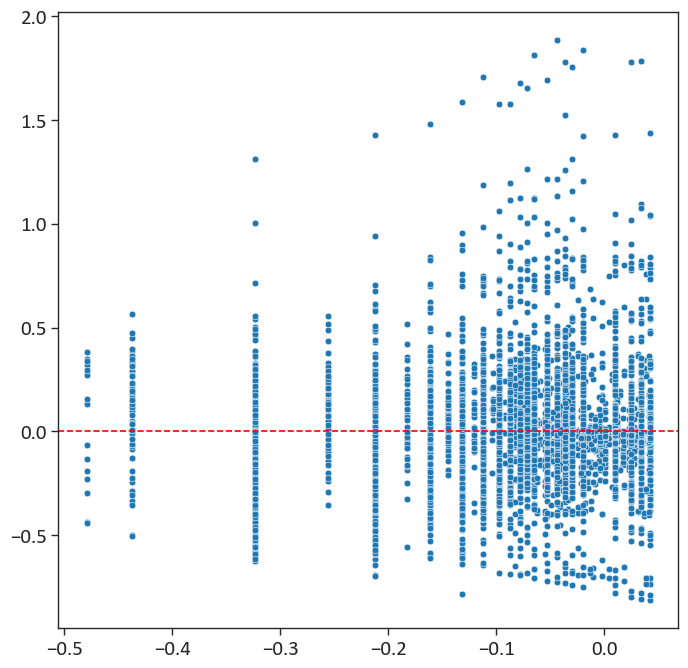

In [ ]:
residuals = newy - result3.predict(newX)
sns.scatterplot(x=result3.predict(newX), y=residuals)
plt.axhline(y=0, color='r', linestyle='--')

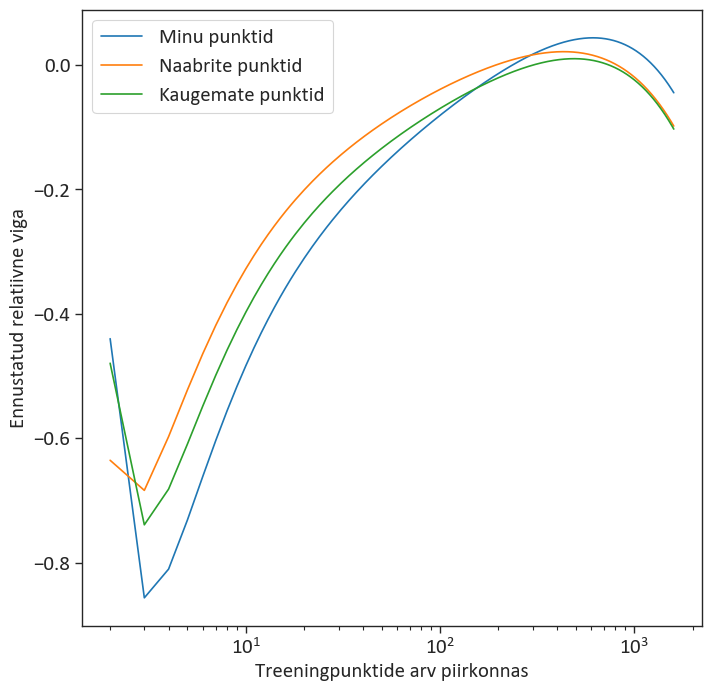

In [ ]:
fig, ax = plt.subplots()
ax.set_xscale('log')
sns.lineplot(x=np.arange(2,1600), y=y1, ax=ax, label="Minu punktid")
sns.lineplot(x=np.arange(2,1600), y=y2, ax=ax, label="Naabrite punktid")
sns.lineplot(x=np.arange(2,1600), y=y3, ax=ax, label="Kaugemate punktid")

ax.set_xlabel("Treeningpunktide arv piirkonnas")
ax.set_ylabel("Ennustatud relatiivne viga")

plt.savefig("plots3/kirjalik_osa/all_points_combos.png")

## Kombineerime need ära

In [ ]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)

suurX["my_points_combo"] = kombineeri_tunnus_mudelist_ja_dfist(result1, suurX)
suurX["neighbour_points_combo"] = kombineeri_tunnus_mudelist_ja_dfist(result2, suurX)
suurX["distant_points_combo"] = kombineeri_tunnus_mudelist_ja_dfist(result3, suurX)

# suurX["my_points_combo"] = result1.params['my_points_logm1'] * suurX.my_points_logm1
# suurX["neighbour_points_combo"] = result2.params['neighbour_points_logm1'] * suurX.neighbour_points_logm1
# suurX["distant_points_combo"] = result3.params['distant_points_logm1'] * suurX.distant_points_logm1


suurX.drop([col for col in suurX.columns if "combo" not in col], axis=1, inplace=True)

# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result4, res4_newX, newy = treeni_ols(suurX, suury)

# summary_table = pd.read_html(result4.summary().as_html(), header=0, index_col=0)
# with pd.ExcelWriter(r"plots3\kirjalik_osa\punkti_combod_kaalud.xlsx", engine='openpyxl') as writer:
#     summary_table[1].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)

result4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            my_rel_diff   R-squared (uncentered):                   0.273
Model:                            OLS   Adj. R-squared (uncentered):              0.273
Method:                 Least Squares   F-statistic:                              1509.
Date:                Fri, 05 May 2023   Prob (F-statistic):                        0.00
Time:                        11:22:04   Log-Likelihood:                          589.61
No. Observations:                8030   AIC:                                     -1175.
Df Residuals:                    8028   BIC:                                     -1161.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
my_points_combo            0.8223      0.043     18.946      0.000       0.737       0.907
neighbour_points_combo     0.2080      0.046      4.514      0.000       0.118       0.298
==============================================================================
Omnibus:                     3143.900   Durbin-Watson:                   0.174
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33742.494
Skew:                           1.570   Prob(JB):                         0.00
Kurtosis:                      12.539   Cond. No.                         4.54
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
for key, val in result4.params.items():
    print(key, val)

my_points_combo 0.8222761470865895
neighbour_points_combo 0.20801235282850833


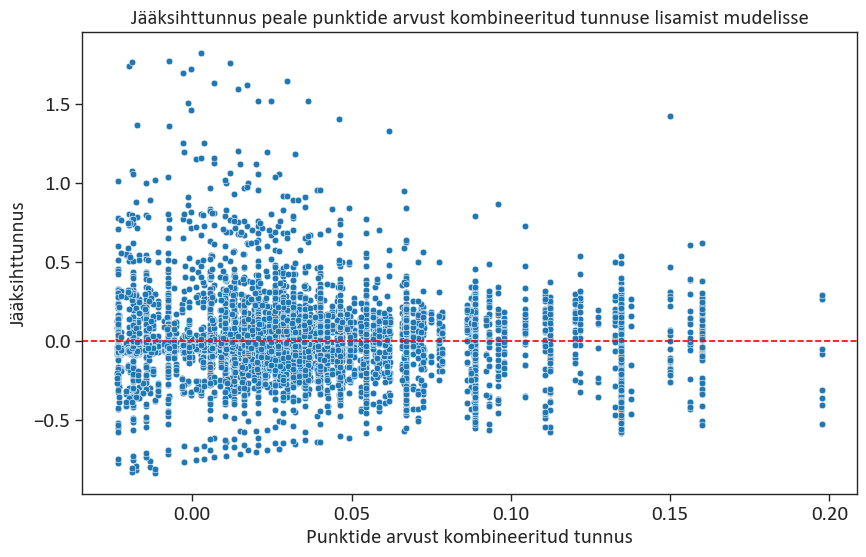

In [ ]:
# result4.predict(newX)
model = result4

residuals = newy - model.predict(res4_newX)

# Create the residual plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=-0.17949021492608008*res4_newX["my_points_combo"]-0.21089102692712736*res4_newX["neighbour_points_combo"], y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel(f'Punktide arvust kombineeritud tunnus')
plt.ylabel('Jääksihttunnus')
plt.title('Jääksihttunnus peale punktide arvust kombineeritud tunnuse lisamist mudelisse')
# plt.savefig('plots3/kirjalik_osa/jaak_peale_punkticombosid.png')
plt.show()

Text(0, 0.5, 'Ennustatud relatiivne viga')

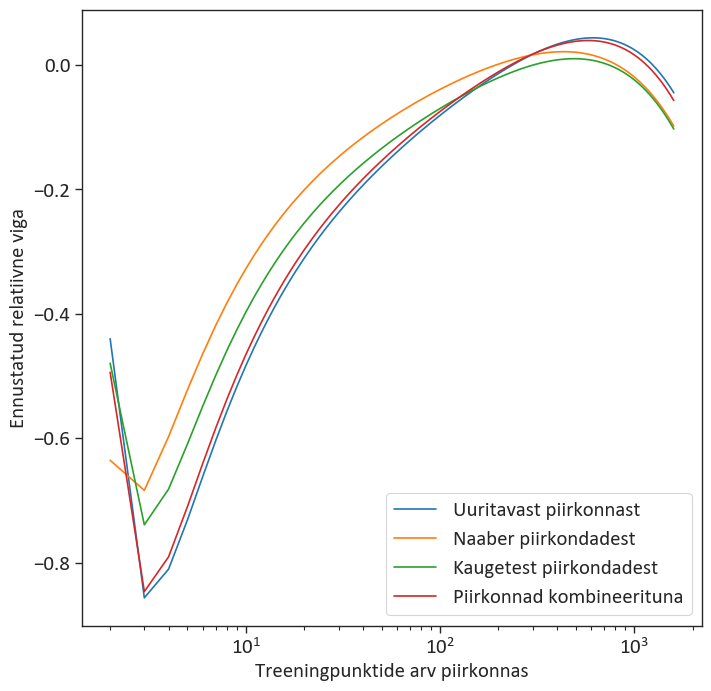

In [ ]:
# const4 = np.ones(shape=y1.shape) 
# y2 = poord_log_punktid * result2.params["neighbour_points_logm1"] + const * result2.params["const"]
# y3 = poord_log_punktid * result3.params["distant_points_logm1"] + const * result3.params["const"]
y4 = y1 * result4.params["my_points_combo"] + y2 * result4.params["neighbour_points_combo"]# + const4 * result4.params["const"]

fig, ax = plt.subplots()
ax.set_xscale('log')
sns.lineplot(x=np.arange(2,1600), y=y1, ax=ax, label="Uuritavast piirkonnast")
sns.lineplot(x=np.arange(2,1600), y=y2, ax=ax, label="Naaber piirkondadest")
sns.lineplot(x=np.arange(2,1600), y=y3, ax=ax, label="Kaugetest piirkondadest")
sns.lineplot(x=np.arange(2,1600), y=y4, ax=ax, label="Piirkonnad kombineerituna")

ax.set_xlabel("Treeningpunktide arv piirkonnas")
ax.set_ylabel("Ennustatud relatiivne viga")

# plt.savefig("plots3/kirjalik_osa/all_points_combos.png")

## komboineerime nad ainult logm1-ga

In [ ]:
def _eraldi_namespace():
    tulemused = []
    for tunnus in ["my_points_logm1", "neighbour_points_logm1", "distant_points_logm1"]:
        suurX = pd.concat(Xid, ignore_index=True)
        suury = pd.concat(yid, ignore_index=True)
        suurX = suurX[[col for col in suurX.columns if col==tunnus]]

        uuritavad_col = suurX.columns
        scaler = MinMaxScaler()
        suurX = scaler.fit_transform(suurX,)
        suurX = pd.DataFrame(suurX, columns=uuritavad_col)
        # suurX = muuda_veergude_nimed_eestikeelseks(suurX)
        result, newX, newy = treeni_ols(suurX, suury)
        # display(result.summary())

        tulemused.append(result)
    return tulemused
tulemused_logm1 = _eraldi_namespace()

suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

# suurX["my_points_combo" ] = suurX["my_points_logm1"]
# suurX["neighbour_points_combo" ] = suurX["neighbour_points_logm1"]
# suurX["distant_points_combo" ] = suurX["distant_points_logm1"]


suurX["my_points_combo" ] = kombineeri_tunnus_mudelist_ja_dfist(tulemused_logm1[0], suurX)
suurX["neighbour_points_combo" ] = kombineeri_tunnus_mudelist_ja_dfist(tulemused_logm1[1], suurX)
suurX["distant_points_combo" ] = kombineeri_tunnus_mudelist_ja_dfist(tulemused_logm1[2], suurX)

suurX = suurX[[col for col in suurX.columns if "combo" in col]]

uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result4, res4_newX, newy = treeni_ols(suurX, suury)

summary_table = pd.read_html(result4.summary().as_html(), header=0, index_col=0)
with pd.ExcelWriter(r"plots3\kirjalik_osa\punkti_combod_kaalud.xlsx", engine='openpyxl') as writer:
    summary_table[1].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)


result4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     960.0
Date:                Fri, 05 May 2023   Prob (F-statistic):               0.00
Time:                        17:42:06   Log-Likelihood:                 555.33
No. Observations:                8030   AIC:                            -1105.
Df Residuals:                    8027   BIC:                            -1084.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.9852      0.021    -46.341      0.000      -1.027      -0.943
my_points_combo            0.7188      0.041     17.641      0.000       0.639       0.799
neighbour_points_combo     0.3597      0.043      8.348      0.000       0.275       0.444
==============================================================================
Omnibus:                     3192.495   Durbin-Watson:                   0.191
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35446.154
Skew:                           1.590   Prob(JB):                         0.00
Kurtosis:                      12.789   Cond. No.                         35.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
tulemused_logm1[0]

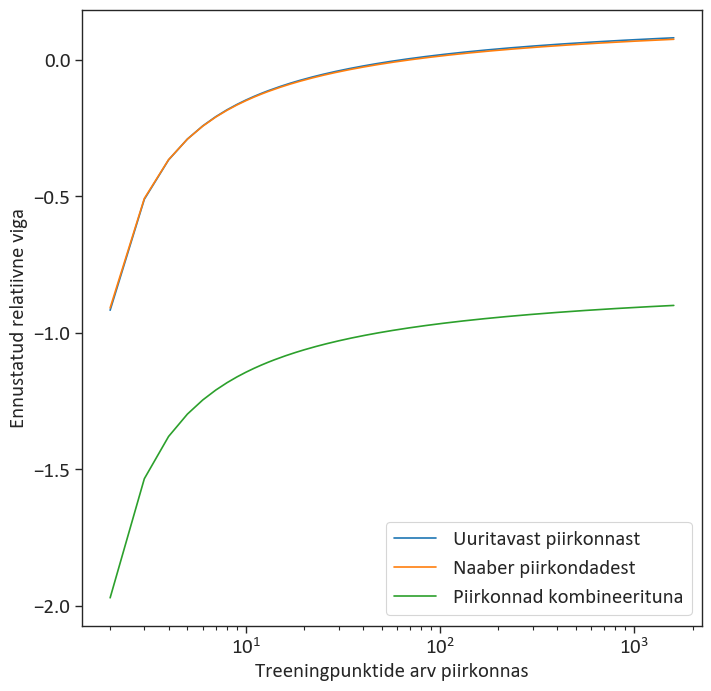

In [ ]:
# const4 = np.ones(shape=y1.shape) 
def _namesmpasdf():
    result1 = tulemused_logm1[0]
    result2 = tulemused_logm1[1]
    def minimax(X): return (X-np.min(X)) / (np.max(X)-np.min(X))
    poord_log_punktid = 1/np.log(np.arange(2,1600))
    poord_log_punktid = minimax(poord_log_punktid)
    y1_2 = poord_log_punktid * result1.params["my_points_logm1"] + np.ones(shape=poord_log_punktid.shape) * result1.params["const"]
    y2_2 = poord_log_punktid * result2.params["neighbour_points_logm1"] + np.ones(shape=poord_log_punktid.shape)*result2.params["const"]

    y4 = y1_2 * result4.params["my_points_combo"] + y2_2 * result4.params["neighbour_points_combo"] + np.ones(shape=poord_log_punktid.shape) * result4.params["const"]

    fig, ax = plt.subplots()
    ax.set_xscale('log')
    # sns.lineplot(x=np.arange(2,1600), y=y1, ax=ax, label="Uuritavast piirkonnast")
    # sns.lineplot(x=np.arange(2,1600), y=y2, ax=ax, label="Naaber piirkondadest")
    # sns.lineplot(x=np.arange(2,1600), y=y3, ax=ax, label="Kaugetest piirkondadest")
    # sns.lineplot(x=np.arange(2,1600), y=y4, ax=ax, label="Piirkonnad kombineerituna")
    sns.lineplot(x=np.arange(2,1600), y=y1_2, ax=ax, label="Uuritavast piirkonnast")
    sns.lineplot(x=np.arange(2,1600), y=y2_2, ax=ax, label="Naaber piirkondadest")
    # sns.lineplot(x=np.arange(2,1600), y=y3, ax=ax, label="Kaugetest piirkondadest")
    sns.lineplot(x=np.arange(2,1600), y=y4, ax=ax, label="Piirkonnad kombineerituna")

    ax.set_xlabel("Treeningpunktide arv piirkonnas")
    ax.set_ylabel("Ennustatud relatiivne viga")
_namesmpasdf()
# plt.savefig("plots3/kirjalik_osa/all_points_combos.png")

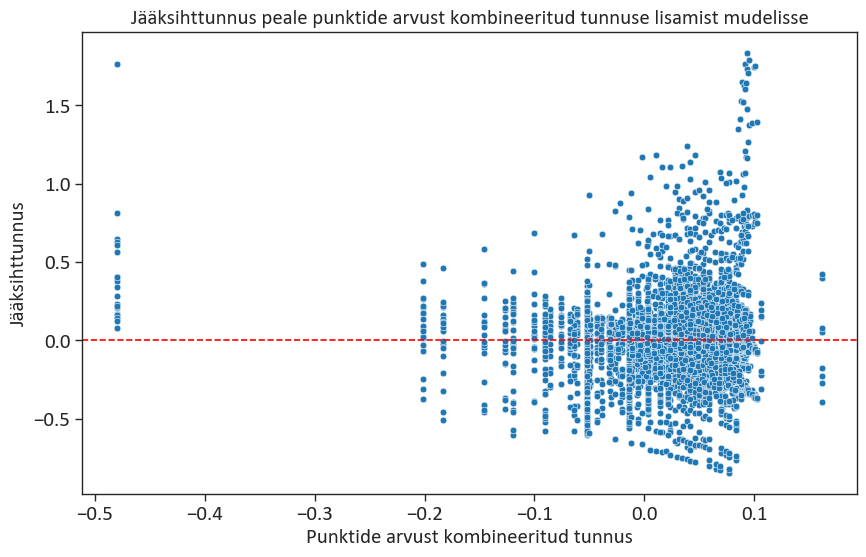

In [ ]:
# result4.predict(newX)
model = result4

residuals = newy - model.predict(res4_newX)

# Create the residual plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=model.params["my_points_combo"]*res4_newX["my_points_combo"]-model.params["neighbour_points_combo"]*res4_newX["neighbour_points_combo"] + np.ones(shape=res4_newX.shape[0])*model.params["const"], y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel(f'Punktide arvust kombineeritud tunnus')
plt.ylabel('Jääk')
plt.title('Jääksihttunnus peale punktide arvust kombineeritud tunnuse lisamist mudelisse')
plt.savefig('plots3/kirjalik_osa/jaak_peale_punkticombosid.png')
plt.show()

## Bpoints

In [ ]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
tagavarasuurX = suurX.copy()
suurX.drop([col for col in suurX.columns if "bpoints" not in col], axis=1, inplace=True)

# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
suury = suury - result4.predict(res4_newX)
result5, res5_newX, newy = treeni_ols(suurX, suury)

summary_table = pd.read_html(result5.summary().as_html(), header=0, index_col=0)
with pd.ExcelWriter(r"plots3\kirjalik_osa\bpunktide_kaalud.xlsx", engine='openpyxl') as writer:
    summary_table[1].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)

result5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     656.8
Date:                Fri, 05 May 2023   Prob (F-statistic):               0.00
Time:                        11:35:10   Log-Likelihood:                 1436.8
No. Observations:                8030   AIC:                            -2866.
Df Residuals:                    8026   BIC:                            -2838.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2157      0.008     26.747      0.000       0.200       0.232
my_bpoints           -0.4285      0.012    -35.043      0.000      -0.452      -0.405
neighbour_bpoints    -0.2156      0.015    -14.198      0.000      -0.245      -0.186
distant_bpoints      -0.2004      0.017    -11.995      0.000      -0.233      -0.168
==============================================================================
Omnibus:                     4194.982   Durbin-Watson:                   0.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            66944.636
Skew:                           2.132   Prob(JB):                         0.00
Kurtosis:                      16.487   Cond. No.                         9.70
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
Xid, yid = loe_andmed_uuesti()
suury = np.concatenate(yid, axis=0)

Text(0, 0.5, 'Jääkviga mida seletada veel')

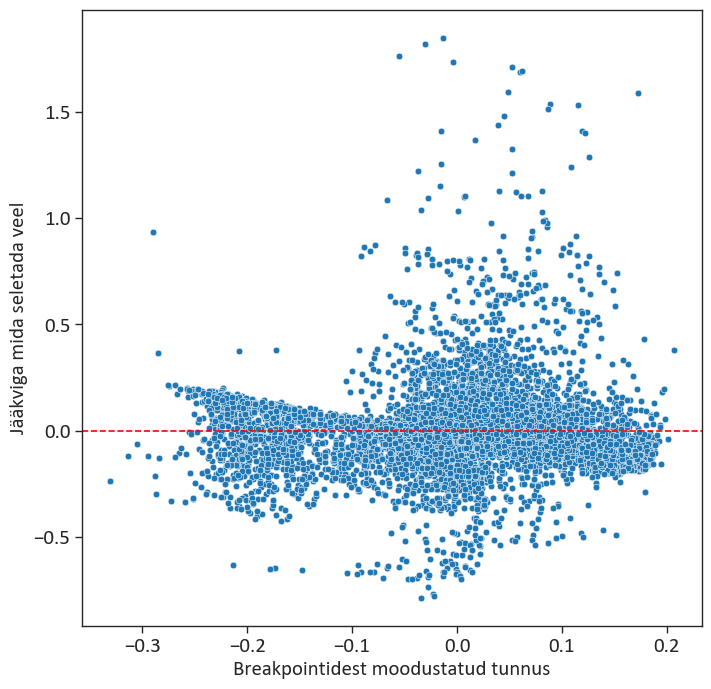

In [ ]:
x5 = res5_newX.const * result5.params["const"] +\
    res5_newX.my_bpoints * result5.params["my_bpoints"] + \
    res5_newX.neighbour_bpoints * result5.params["neighbour_bpoints"] + \
    res5_newX.distant_bpoints * result5.params["distant_bpoints"]

fig, ax = plt.subplots()
# ax.set_xscale('log')
residuals = suury - result5.predict(res5_newX)
sns.scatterplot(x=x5, y=residuals, ax=ax)#, hue=tagavarasuurX.neighbour_bpoints)
plt.axhline(y=0, color='r', linestyle='--')
ax.set_title("")
ax.set_xlabel("Breakpointidest moodustatud tunnus")
ax.set_ylabel("Jääkviga mida seletada veel")

# plt.savefig("plots3/kirjalik_osa/bpoints_combo_kaalud.png")

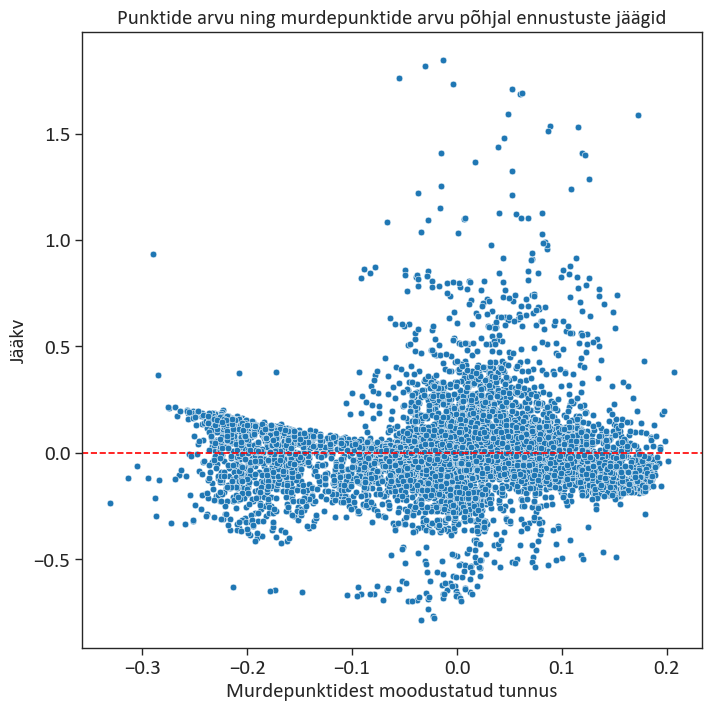

In [ ]:
x5 = res5_newX.const * result5.params["const"] +\
    res5_newX.my_bpoints * result5.params["my_bpoints"] + \
    res5_newX.neighbour_bpoints * result5.params["neighbour_bpoints"] + \
    res5_newX.distant_bpoints * result5.params["distant_bpoints"]


fig, ax = plt.subplots()
# ax.set_xscale('log')
residuals = newy - result5.predict(res5_newX)
sns.scatterplot(x=x5, y=residuals, ax=ax)#, hue=tagavarasuurX.neighbour_bpoints)
plt.axhline(y=0, color='r', linestyle='--')
ax.set_title("Punktide arvu ning murdepunktide arvu põhjal ennustuste jäägid")
ax.set_xlabel("Murdepunktidest moodustatud tunnus")
ax.set_ylabel("Jääkv")

plt.savefig("plots3/kirjalik_osa/bpoints_combo_kaalud.png")

### Bpoints ja points kombineerituna


In [ ]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
tagavarasuurX = suurX.copy()

suurX["my_points_combo"] = suurX.my_points_logm1
suurX["neighbour_points_combo"] = suurX.neighbour_points_logm1
suurX["distant_points_combo"] =  suurX.distant_points_logm1
suurX["points_combo"] = kombineeri_tunnus_mudelist_ja_dfist(result4, suurX)

suurX["bpoints_combo"] = kombineeri_tunnus_mudelist_ja_dfist(result5, suurX)


suurX.drop([col for col in suurX.columns if col not in ['points_combo', 'bpoints_combo']], axis=1, inplace=True)

# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result6, res6_newX, newy = treeni_ols(suurX, suury)

# summary_table = pd.read_html(result5.summary().as_html(), header=0, index_col=0)
# with pd.ExcelWriter(r"plots3\kirjalik_osa\point_ja_bpoint_kaalud.xlsx", engine='openpyxl') as writer:
#     summary_table[1].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)

result6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     2199.
Date:                Fri, 05 May 2023   Prob (F-statistic):               0.00
Time:                        11:47:05   Log-Likelihood:                 1448.2
No. Observations:                8030   AIC:                            -2890.
Df Residuals:                    8027   BIC:                            -2869.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0078      0.003      2.812      0.005       0.002       0.013
points_combo      1.0982      0.021     53.471      0.000       1.058       1.138
bpoints_combo     1.0116      0.023     44.711      0.000       0.967       1.056
==============================================================================
Omnibus:                     4163.527   Durbin-Watson:                   0.230
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            65889.312
Skew:                           2.113   Prob(JB):                         0.00
Kurtosis:                      16.382   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Jääkviga ennustatud tunnusest')

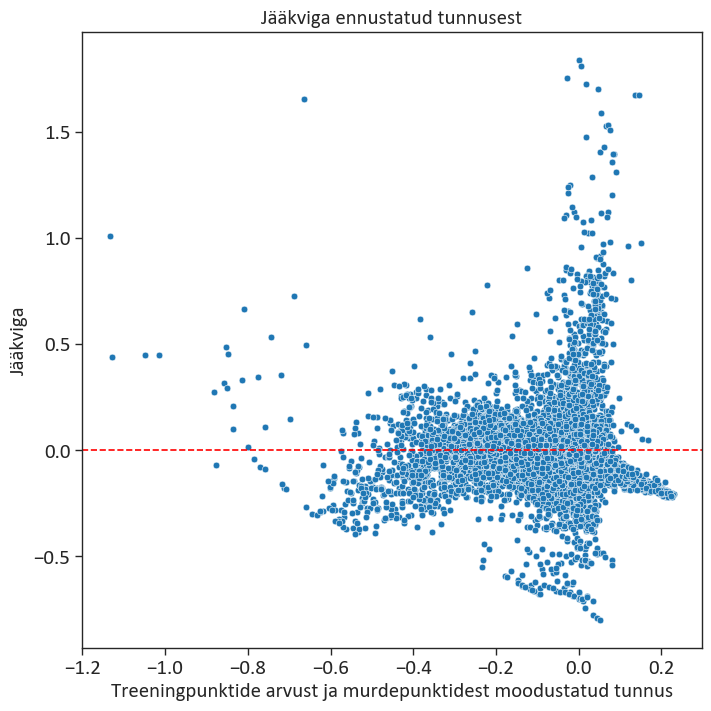

In [ ]:
residuals = newy - result6.predict(res6_newX)
x = result6.predict(res6_newX)
sns.scatterplot(x=x, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Treeningpunktide arvust ja murdepunktidest moodustatud tunnus")
plt.ylabel("Jääkviga")
plt.title("Jääkviga ennustatud tunnusest")
# plt.savefig("plots3/kirjalik_osa/point_ja_bpoint_jaak.png")

## raw_mean jaoks
ei ole mõtet sest r tuleb mingi 0.06

In [ ]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)

suury = suury - result6.predict(res6_newX)

suurX.drop([col for col in suurX.columns if "raw_mean" not in col], axis=1, inplace=True)

# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result7, res7_newX, newy = treeni_ols(suurX, suury)

summary_table = pd.read_html(result7.summary().as_html(), header=0, index_col=0)
with pd.ExcelWriter(r"plots3\kirjalik_osa\raw_mean_kombineeritult_kaalud.xlsx", engine='openpyxl') as writer:
    summary_table[1].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)

result7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     96.64
Date:                Fri, 05 May 2023   Prob (F-statistic):           1.92e-61
Time:                        11:47:34   Log-Likelihood:                 1590.7
No. Observations:                8030   AIC:                            -3173.
Df Residuals:                    8026   BIC:                            -3145.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1075      0.007    -14.427      0.000      -0.122      -0.093
my_raw_mean2           -0.1980      0.036     -5.513      0.000      -0.268      -0.128
neighbour_raw_mean2     0.2863      0.033      8.556      0.000       0.221       0.352
distant_raw_mean2       0.3447      0.022     15.392      0.000       0.301       0.389
==============================================================================
Omnibus:                     3882.676   Durbin-Watson:                   0.239
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            52069.526
Skew:                           1.978   Prob(JB):                         0.00
Kurtosis:                      14.831   Cond. No.                         21.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

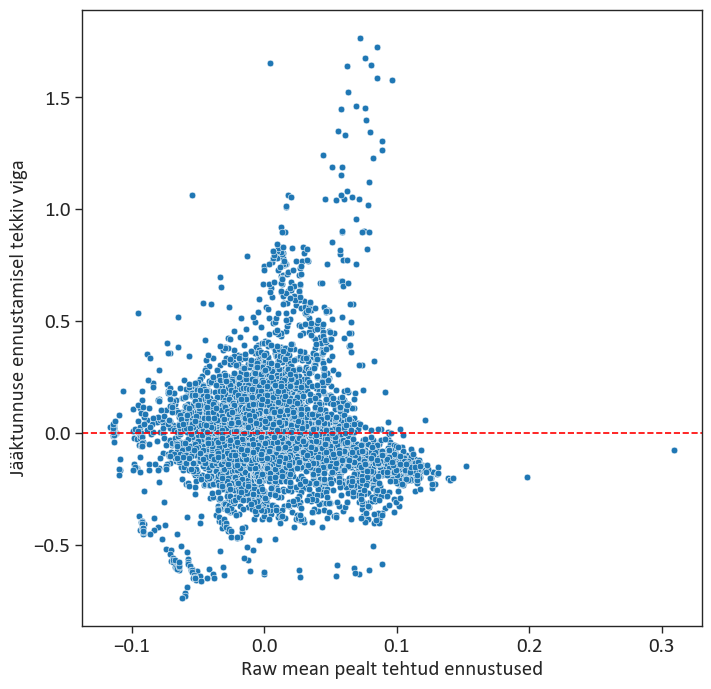

In [ ]:
# y7 = kombineeri_tunnus_mudelist_ja_dfist(result7, res7_newX)
y = newy - result7.predict(res7_newX)
x = result7.predict(res7_newX)

fig, ax = plt.subplots()
# ax.set_xscale('log')
def inverse_minimax(X):
    return  X * (1600-2) + 2
sns.scatterplot(x=x, y=y, ax=ax)#, hue=tagavarasuurX.distant_raw_mean2)
plt.axhline(y=0, color='r', linestyle='--')
ax.set_xlabel("Raw mean pealt tehtud ennustused")
ax.set_ylabel("Jääktunnuse ennustamisel tekkiv viga")

plt.savefig("plots3/kirjalik_osa/raw_mean_kombineeritult_jaak.png")

## Vaatame mis kombod olemas on juba

In [ ]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

uuritavad_col = suurX.columns
reg_scaler = MinMaxScaler()
suurX = reg_scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)

# TODO üle käia ega need olemasolevad elemendid ei muutu
res1, res2, res3 = tulemused_logm1

suurX["my_points_combo"] = kombineeri_tunnus_mudelist_ja_dfist(res1, suurX)
suurX["neighbour_points_combo"] = kombineeri_tunnus_mudelist_ja_dfist(res2, suurX)
suurX["distant_points_combo"] =  kombineeri_tunnus_mudelist_ja_dfist(res3, suurX)
suurX["points_combo"] = kombineeri_tunnus_mudelist_ja_dfist(result4, suurX)

suurX["bpoints_combo"] = kombineeri_tunnus_mudelist_ja_dfist(result5, suurX)

# suurX["raw_mean_combo"] = kombineeri_tunnus_mudelist_ja_dfist(result6, suurX)

# 'my_raw_mean2','neighbour_raw_mean2', 'distant_raw_mean2',
# 'mse_treeningul', 'points_combo', 'bpoints_combo'

suurX.drop(['my_bpoints', 'neighbour_bpoints', 'distant_bpoints', 
        'my_points','neighbour_points_combo', 'my_points_combo', 
       'neighbour_points', 'distant_points', 'my_points_m1', 'my_points_log',
       'my_points_logm1', 'neighbour_points_m1', 'neighbour_points_log',
       'neighbour_points_logm1', 'distant_points_m1', 'distant_points_log',
       'distant_points_logm1',
    #    'my_raw_mean2','neighbour_raw_mean2', 'distant_raw_mean2',
         ], axis=1, inplace=True)

# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result8, res8_newX, newy = treeni_ols(suurX, suury)
regressioon_mudel, res8_newX, newy = treeni_ols(suurX, suury)

summary_table = pd.read_html(result8.summary().as_html(), header=0, index_col=0)
with pd.ExcelWriter(r"plots3\kirjalik_osa\engineered_kaalud.xlsx", engine='openpyxl') as writer:
    summary_table[1].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)

# print("MSE treeningul: ", mean_squared_error(newy, result8.predict(newX)))
result8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     943.2
Date:                Fri, 05 May 2023   Prob (F-statistic):               0.00
Time:                        12:01:57   Log-Likelihood:                 1837.4
No. Observations:                8030   AIC:                            -3661.
Df Residuals:                    8023   BIC:                            -3612.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0591      0.009     -6.654      0.000      -0.076      -0.042
my_raw_mean2           -0.0871      0.037     -2.360      0.018      -0.159      -0.015
neighbour_raw_mean2     0.5438      0.035     15.701      0.000       0.476       0.612
distant_raw_mean2       0.6360      0.025     25.151      0.000       0.586       0.686
mse_treeningul         -0.2948      0.013    -22.546      0.000      -0.320      -0.269
points_combo           -1.0182      0.020    -50.507      0.000      -1.058      -0.979
bpoints_combo           0.8669      0.026     32.741      0.000       0.815       0.919
==============================================================================
Omnibus:                     3591.618   Durbin-Watson:                   0.245
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            44789.036
Skew:                           1.809   Prob(JB):                         0.00
Kurtosis:                      13.990   Cond. No.                         23.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

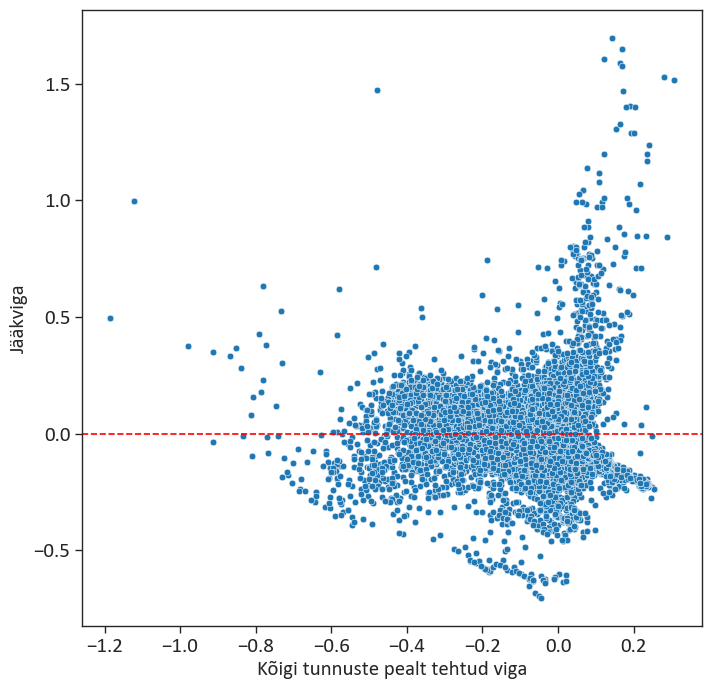

In [ ]:
residual = newy - result8.predict(res8_newX)
x = result8.predict(res8_newX)

fig, ax = plt.subplots()

sns.scatterplot(x=x, y=residual, ax=ax)#, hue=tagavarasuurX.distant_raw_mean2)
plt.axhline(y=0, color='r', linestyle='--')
ax.set_xlabel("Kõigi tunnuste pealt tehtud viga")
ax.set_ylabel("Jääkviga")

plt.savefig("plots3/kirjalik_osa/mudeli_vead_meaneraldi_jaak.png")

Text(0, 0.5, 'Jääkviga')

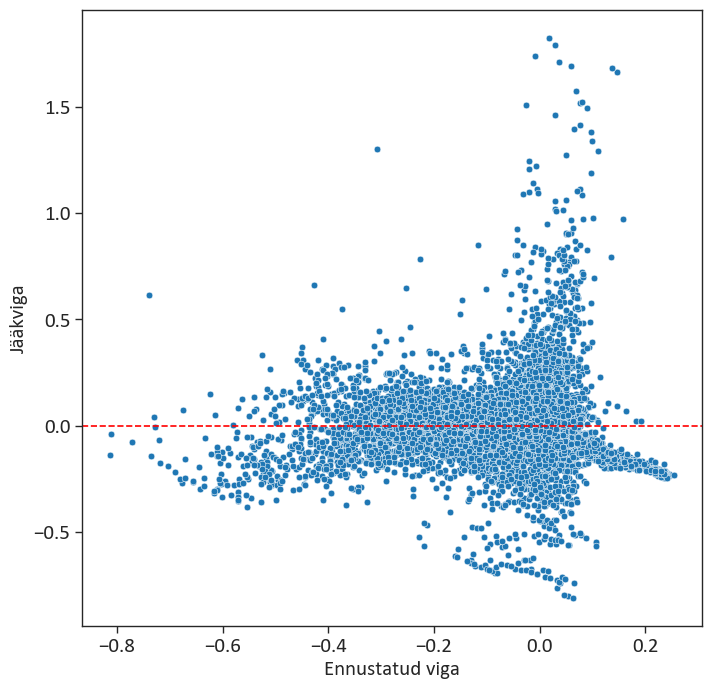

In [ ]:
x8 = kombineeri_tunnus_mudelist_ja_dfist(result8, newX)
y8 = suury - result8.predict(newX)

fig, ax = plt.subplots()
sns.scatterplot(x=x8, y=y8, ax=ax)#, hue=tagavarasuurX.distant_raw_mean2)
plt.axhline(y=0, color='r', linestyle='--')

ax.set_xlabel("Ennustatud viga")
ax.set_ylabel("Jääkviga")

# plt.savefig("plots3/kirjalik_osa/final.png")

In [ ]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

uuritavad_col = suurX.columns
reg_scaler = MinMaxScaler()
suurX = reg_scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)

# TODO üle käia ega need olemasolevad elemendid ei muutu
res1, res2, res3 = tulemused_logm1
suurX["my_points_combo"] = kombineeri_tunnus_mudelist_ja_dfist(res1, suurX)
suurX["neighbour_points_combo"] = kombineeri_tunnus_mudelist_ja_dfist(res2, suurX)
suurX["distant_points_combo"] =  kombineeri_tunnus_mudelist_ja_dfist(res3, suurX)

suurX["points_combo"] = kombineeri_tunnus_mudelist_ja_dfist(result4, suurX)
suurX["bpoints_combo"] = kombineeri_tunnus_mudelist_ja_dfist(result5, suurX)
suurX["raw_mean_combo"] = kombineeri_tunnus_mudelist_ja_dfist(result6, suurX)

# 'my_raw_mean2','neighbour_raw_mean2', 'distant_raw_mean2',
# 'mse_treeningul', 'points_combo', 'bpoints_combo'

suurX.drop(['my_bpoints', 'neighbour_bpoints', 'distant_bpoints', 
        'my_points','neighbour_points_combo', 'my_points_combo', 
       'neighbour_points', 'distant_points', 'my_points_m1', 'my_points_log',
       'my_points_logm1', 'neighbour_points_m1', 'neighbour_points_log',
       'neighbour_points_logm1', 'distant_points_m1', 'distant_points_log',
       'distant_points_logm1',
       'my_raw_mean2','neighbour_raw_mean2', 'distant_raw_mean2',
         ], axis=1, inplace=True)

# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result9, res9_newX, newy = treeni_ols(suurX, suury)
regressioon_mudel_combo_mean, res9_newX, newy = treeni_ols(suurX, suury)

summary_table = pd.read_html(result9.summary().as_html(), header=0, index_col=0)
with pd.ExcelWriter(r"plots3\kirjalik_osa\engineered_kaalud_combo_mean.xlsx", engine='openpyxl') as writer:
    summary_table[1].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)

# print("MSE treeningul: ", mean_squared_error(newy, result9.predict(newX)))
result9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     1501.
Date:                Fri, 05 May 2023   Prob (F-statistic):               0.00
Time:                        01:27:15   Log-Likelihood:                 1482.4
No. Observations:                8030   AIC:                            -2957.
Df Residuals:                    8026   BIC:                            -2929.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1363      0.005     28.110      0.000       0.127       0.146
mse_treeningul    -0.0882      0.011     -8.283      0.000      -0.109      -0.067
points_combo      -1.0229      0.016    -64.390      0.000      -1.054      -0.992
bpoints_combo      1.0617      0.018     60.172      0.000       1.027       1.096
raw_mean_combo    -0.0483      0.009     -5.105      0.000      -0.067      -0.030
==============================================================================
Omnibus:                     4098.261   Durbin-Watson:                   0.233
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            66782.158
Skew:                           2.058   Prob(JB):                         0.00
Kurtosis:                      16.515   Cond. No.                     3.19e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.06e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

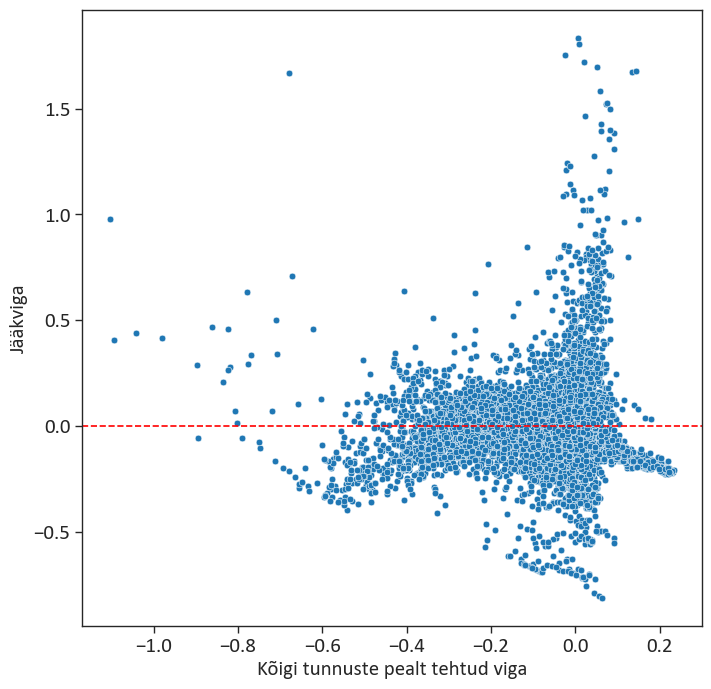

In [ ]:
residual = newy - result9.predict(res9_newX)
x = result9.predict(res9_newX)

fig, ax = plt.subplots()

sns.scatterplot(x=x, y=residual, ax=ax)#, hue=tagavarasuurX.distant_raw_mean2)
plt.axhline(y=0, color='r', linestyle='--')
ax.set_xlabel("Kõigi tunnuste pealt tehtud viga")
ax.set_ylabel("Jääkviga")

plt.savefig("plots3/kirjalik_osa/mudeli_vead_kombomean_jaak.png")

In [ ]:
import pickle
with open('ols_model.pkl', 'wb') as f:
    pickle.dump(regressioon_mudel, f)
with open('regression_scaler.pkl', 'wb') as f:
    pickle.dump(reg_scaler, f)

<AxesSubplot: >

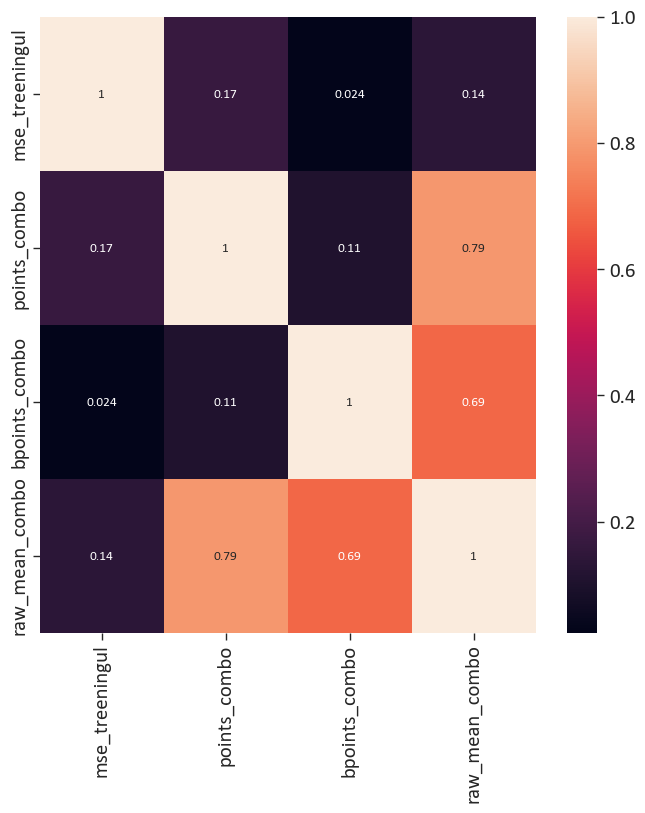

In [ ]:
sns.heatmap(res8_newX.loc[:, res8_newX.columns != "const"].corr(), annot=True)

# Jääksutunnused

In [ ]:
np.abs(regressioon_mudel.params)

const                  0.157993
my_raw_mean2           0.099671
neighbour_raw_mean2    0.542951
distant_raw_mean2      0.631871
mse_treeningul         0.286550
points_combo           1.035521
bpoints_combo          0.876438
dtype: float64

In [ ]:
np.argsort(np.abs(regressioon_mudel.params))

const                  1
my_raw_mean2           0
neighbour_raw_mean2    4
distant_raw_mean2      2
mse_treeningul         3
points_combo           6
bpoints_combo          5
dtype: int64

In [ ]:
for a in np.argsort(np.abs(regressioon_mudel.params))[-2::-1]:
    print(regressioon_mudel.params[a])

0.8764377612107305
0.631871147325703
0.542951354933315
-0.28654966467793636
-0.15799272615522303
-0.09967090134387427


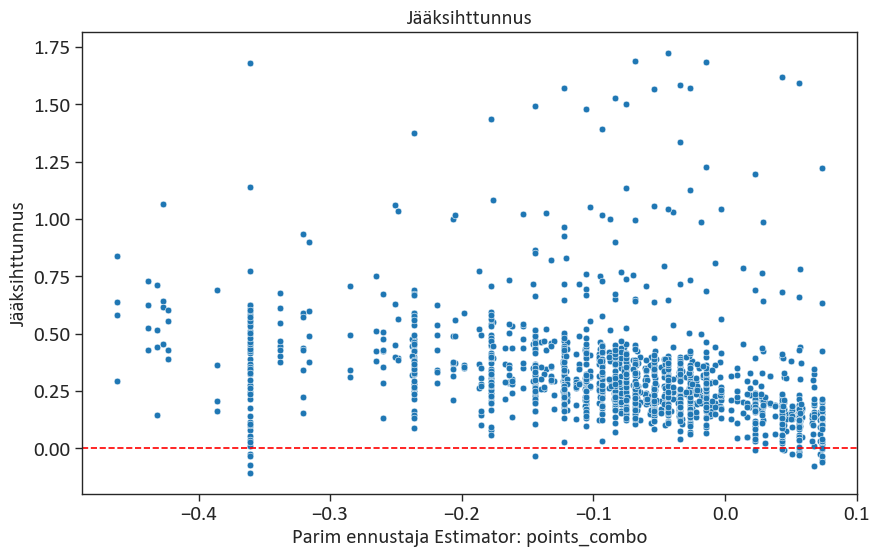

In [ ]:
model = regressioon_mudel
best_estimator = newX.columns[np.argmax(np.abs(model.params))]

y_pred = model.predict(newX)
residuals = y - y_pred

# Create the residual plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=newX[best_estimator], y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel(f'Parim ennustaja Estimator: {best_estimator}')
plt.ylabel('Jääksihttunnus')
plt.title('Jääksihttunnus')
plt.show()

bpoints_combo


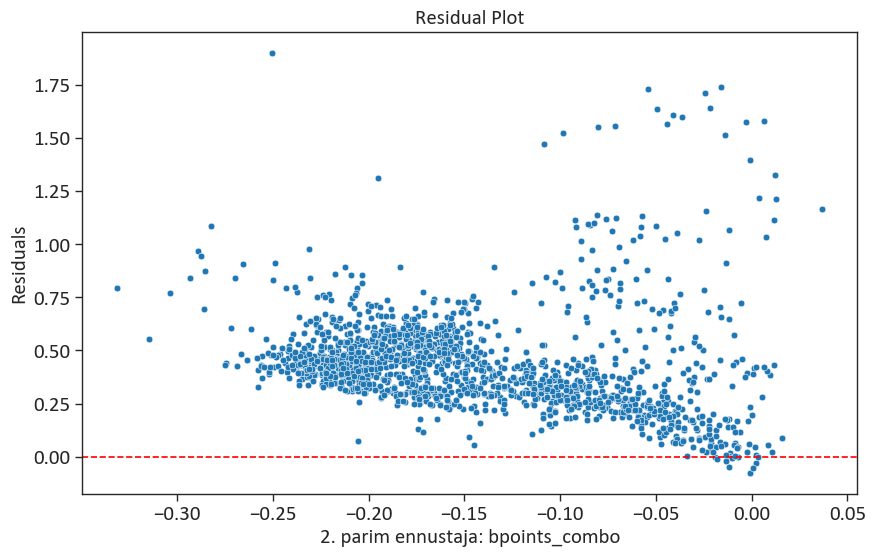

distant_raw_mean2


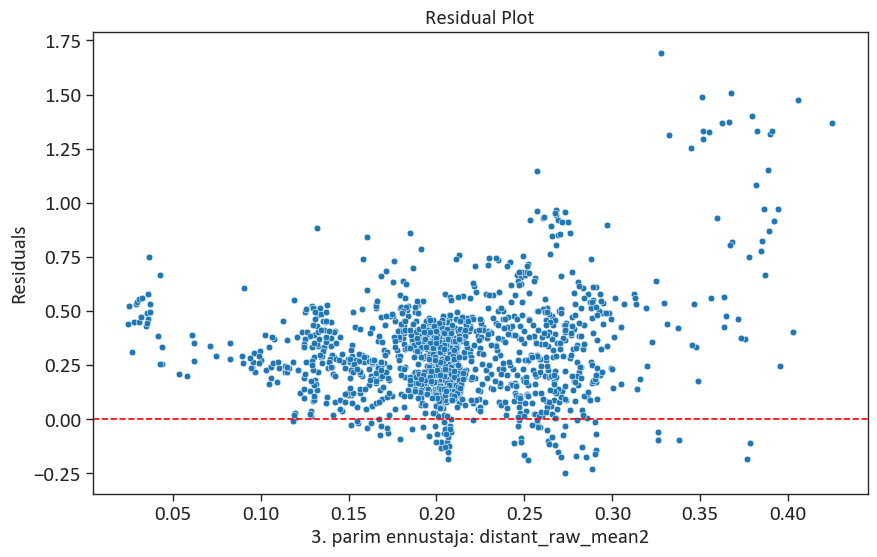

neighbour_raw_mean2


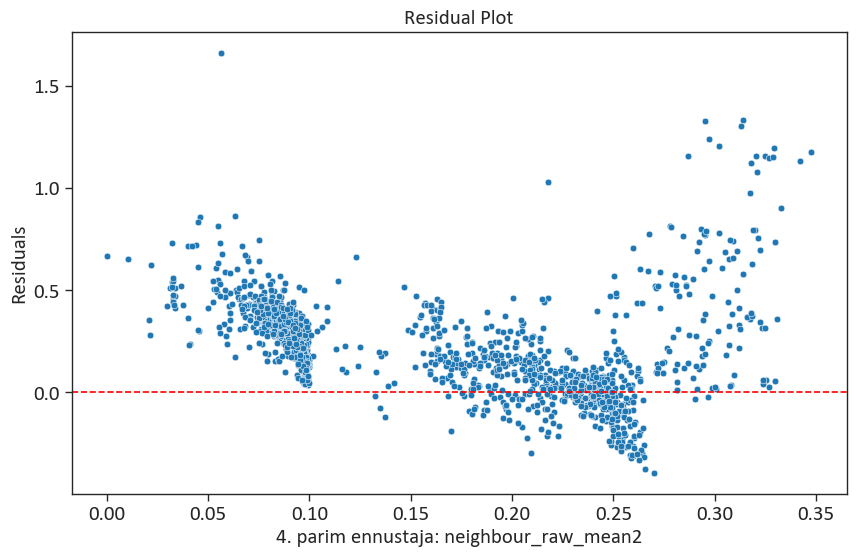

mse_treeningul


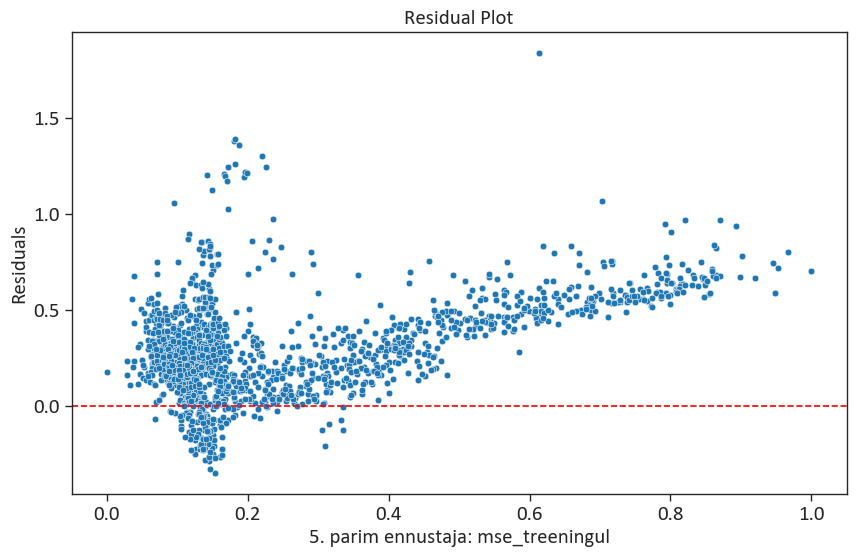

const


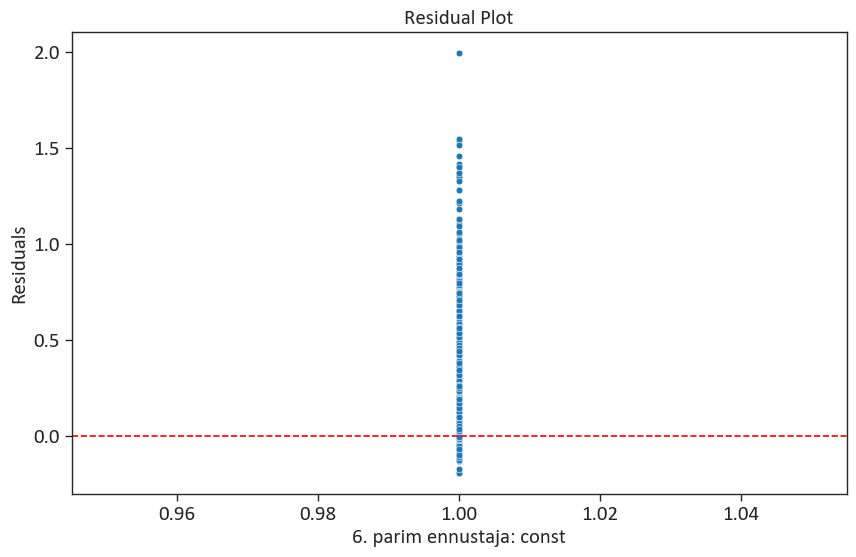

my_raw_mean2


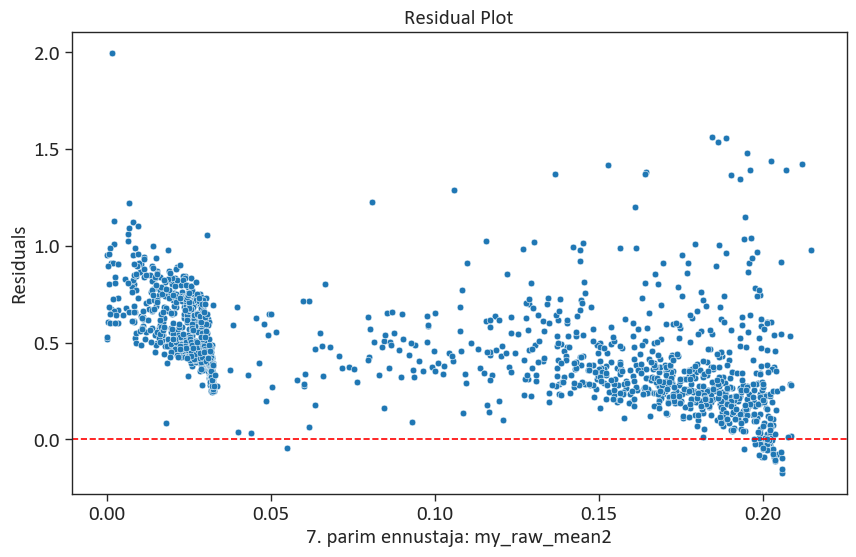

In [ ]:
jarjekord = np.argsort(np.abs(regressioon_mudel.params))[-2::-1]
for idx, best_est in enumerate(jarjekord):
    best_est = model.params.keys()[best_est]
    print(best_est)
    residuals = residuals - model.params[best_est] * newX[best_est]
    # Create the residual plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=newX[best_est], y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel(f'{idx+2}. parim ennustaja: {best_est}')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()

# Jääktunnused v2
jääk - vist oli mõte nii, et kõige parema järgi teha ennustused ja siis joonistada x-teljele paremuselt teine tunnus ja y-teljele esimesest jäänud jääk. Ehk natuke sarnane selle lingi taga olevale teisele joonisele, aga x-telg oleks juba see teine tunnus. Vist...?

In [ ]:
for a in np.argsort(np.abs(regressioon_mudel.params))[::-1]:
    print(newX.columns[a], a, regressioon_mudel.params[a])


points_combo 5 1.0355212966328016
bpoints_combo 6 0.8764377612107305
distant_raw_mean2 3 0.631871147325703
neighbour_raw_mean2 2 0.542951354933315
mse_treeningul 4 -0.28654966467793636
const 0 -0.15799272615522303
my_raw_mean2 1 -0.09967090134387427


points_combo 1.0355212966328016


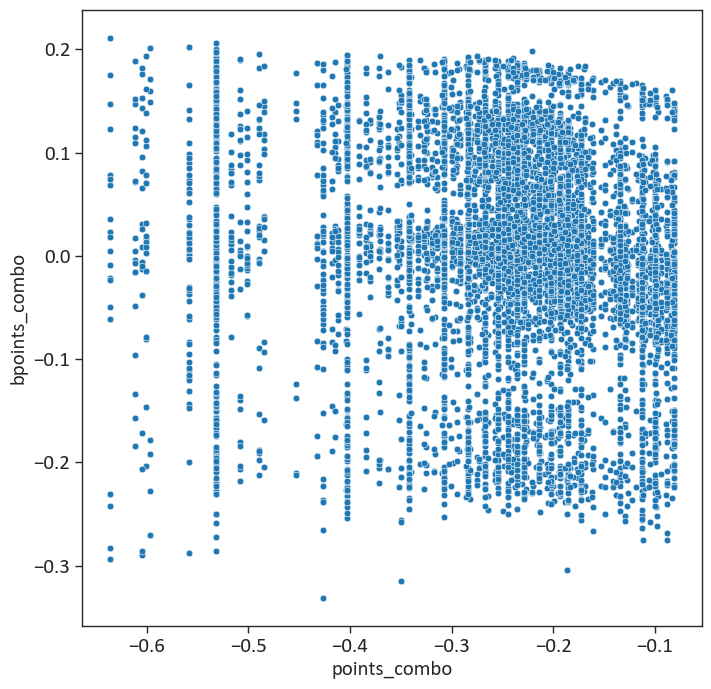

bpoints_combo


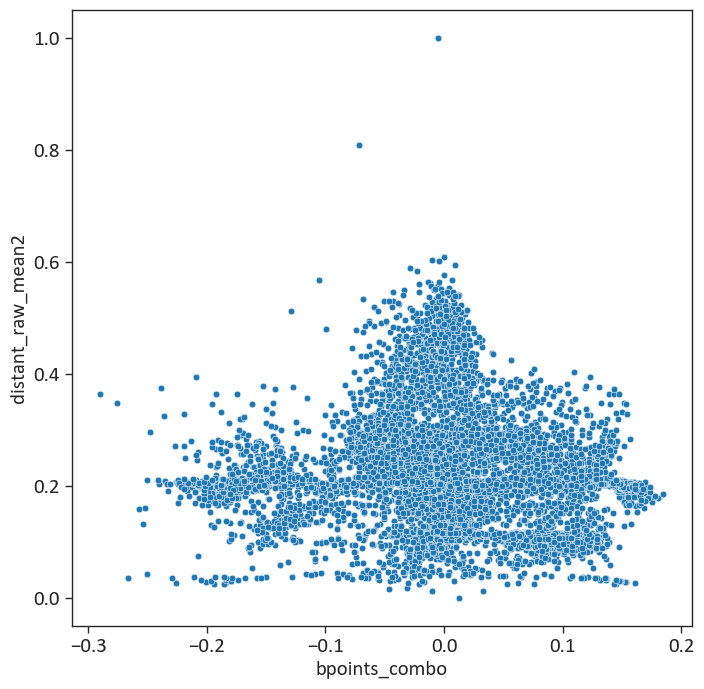

distant_raw_mean2


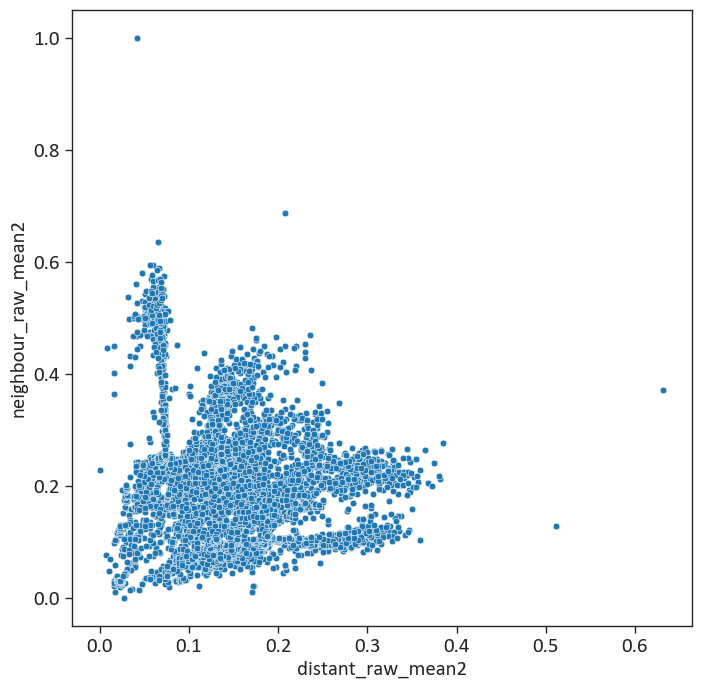

neighbour_raw_mean2


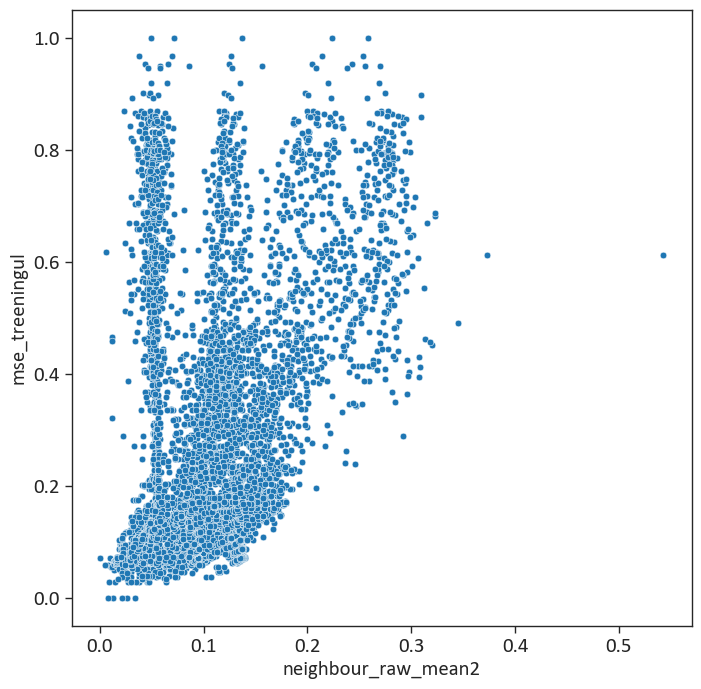

mse_treeningul


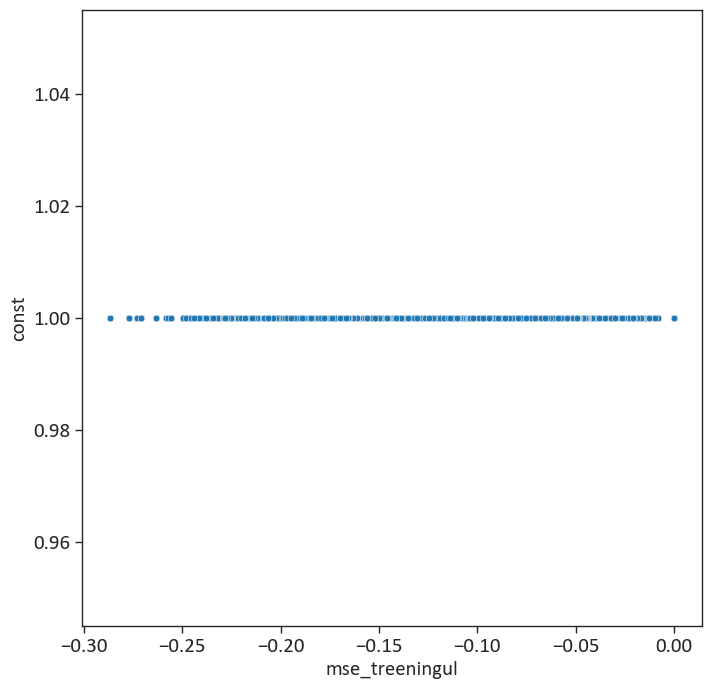

const


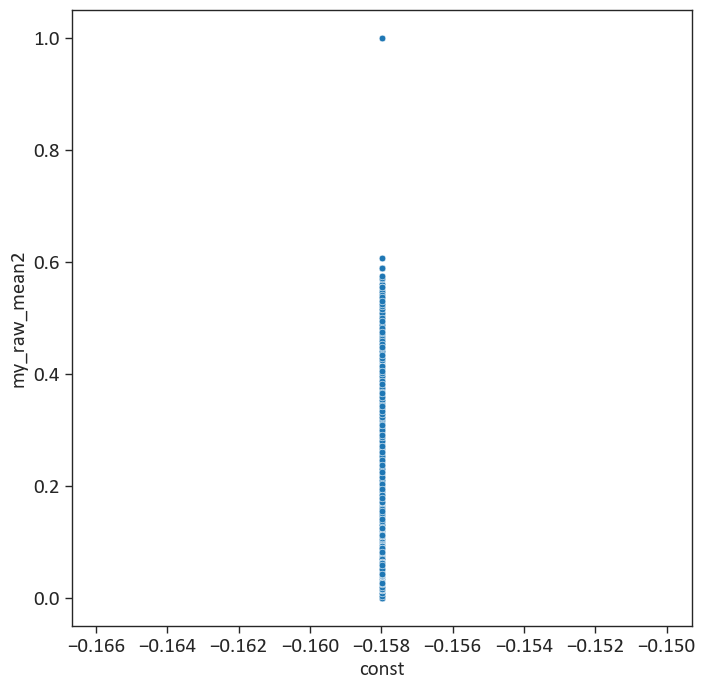

my_raw_mean2


IndexError: index 7 is out of bounds for axis 0 with size 7

In [ ]:
model = regressioon_mudel
jarjekord = np.argsort(np.abs(regressioon_mudel.params))[::-1]


j = jarjekord[0]

y_pred = newX[newX.columns[j]] * model.params[j] + np.ones(shape=newX.shape[0]) * model.params["const"]

print(newX.columns[j], model.params[j])
sns.scatterplot(x=y_pred, y=newX[newX.columns[jarjekord[0+1]]])
plt.xlabel(f"{newX.columns[j]}")
plt.show()

for idx, i in enumerate(jarjekord[1:], start=1):
    col = newX.columns[i] 
    print(col)
    y_pred = newX[col] * model.params[col]
    sns.scatterplot(x=y_pred, y=newX[newX.columns[jarjekord[idx+1]]])
    plt.xlabel(f"{col}")
    plt.show()

# Jamps

<AxesSubplot: ylabel='Count'>

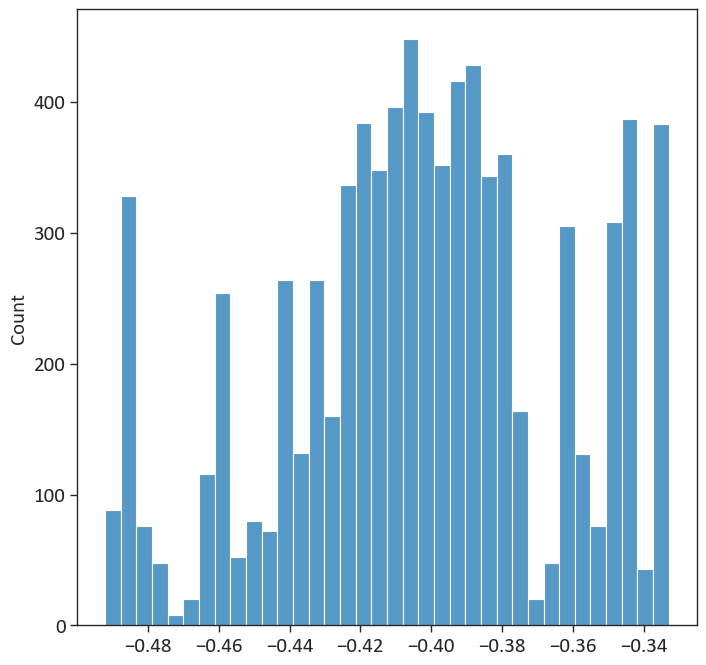

In [ ]:
from scipy.stats import boxcox

sns.histplot(boxcox(suurX.points_combo+0.5)[0])

# Loeme sisse ja ennustame?

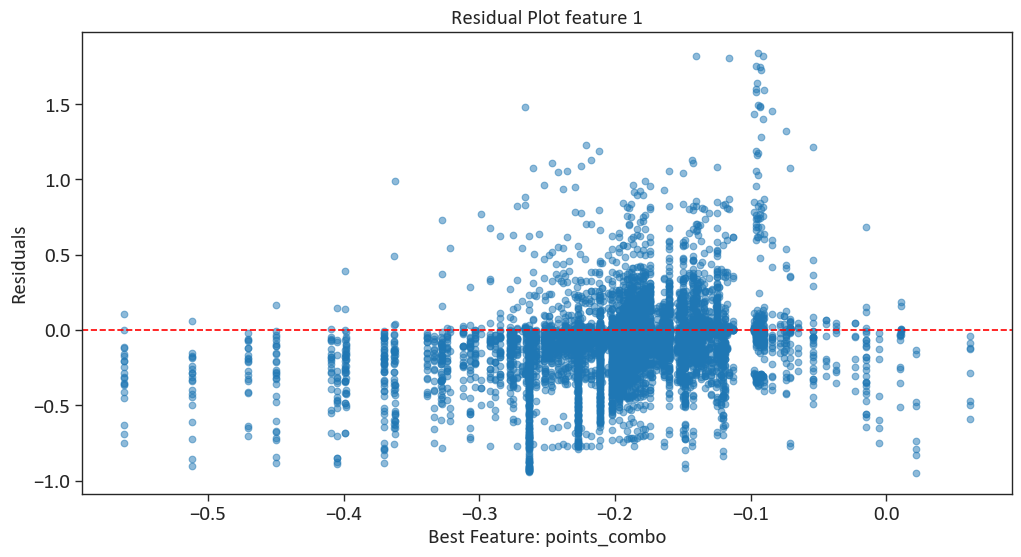

In [ ]:
# Make predictions on the test set
y_pred = regressioon_mudel.predict(newX)

# Calculate the residuals
residuals = newy - y_pred

# Plot the residual plot with the best feature on the x-axis
x = newX.points_combo * result7.params["points_combo"] + result7.params["const"]
plt.figure(figsize=(12, 6))
plt.scatter(x=x, y=newy, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel(f"Best Feature: points_combo")
plt.ylabel("Residuals")
plt.title("Residual Plot feature 1")
plt.show()


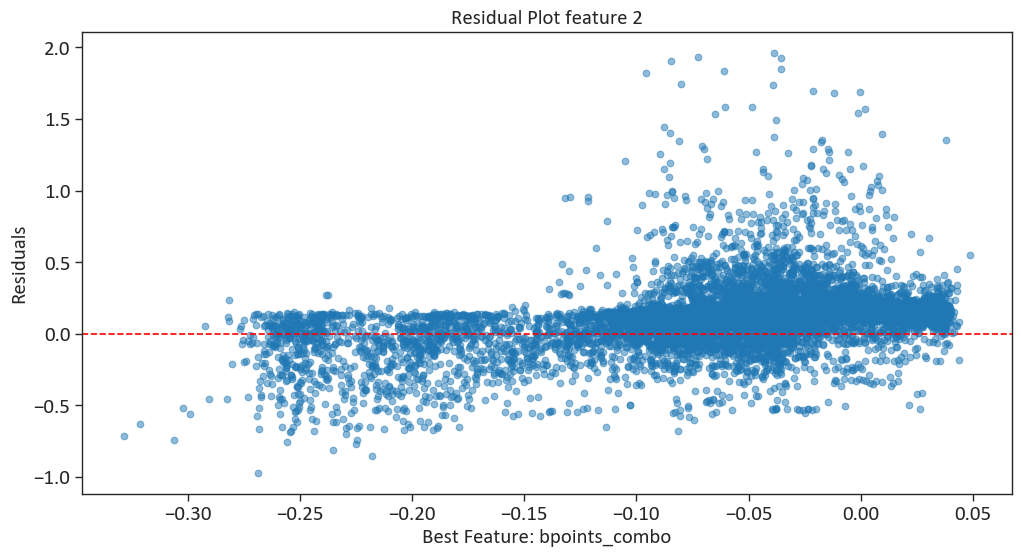

In [ ]:
# Make predictions on the test set

# Calculate the residuals
y2 = newy - x

# Plot the residual plot with the best feature on the x-axis
x2 = newX.bpoints_combo * result7.params["bpoints_combo"] 
plt.figure(figsize=(12, 6))
plt.scatter(x=x2, y=y2, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel(f"Best Feature: bpoints_combo")
plt.ylabel("Residuals")
plt.title("Residual Plot feature 2")
plt.show()